In [46]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer
from sklearn.manifold import TSNE

In [3]:
# load dataset
df = pd.read_csv('data_4.csv')
print(df.shape)
df.head()

(28458, 84)


id.orig_p  id.resp_p proto service  flow_duration  fwd_pkts_tot  \
0      38667       1883   tcp    mqtt      32.011598             9   
1      51143       1883   tcp    mqtt      31.883584             9   
2      44761       1883   tcp    mqtt      32.124053             9   
3      60893       1883   tcp    mqtt      31.961063             9   
4      51087       1883   tcp    mqtt      31.902362             9   

   bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  ...  \
0             5                  3                  3          0.281148  ...   
1             5                  3                  3          0.282277  ...   
2             5                  3                  3          0.280164  ...   
3             5                  3                  3          0.281593  ...   
4             5                  3                  3          0.282111  ...   

   active.std     idle.min     idle.max     idle.tot     idle.avg  idle.std  \
0         0.0  29729182.96  29729182.96  29729182.96  29729182.96       0.0   
1         0.0  29855277.06  29855277.06  29855277.06  29855277.06       0.0   
2         0.0  29842149.02  29842149.02  29842149.02  29842149.02       0.0   
3         0.0  29913774.97  29913774.97  29913774.97  29913774.97       0.0   
4         0.0  29814704.90  29814704.90  29814704.90  29814704.90       0.0   

   fwd_init_window_size  bwd_init_window_size  fwd_last_window_size  \
0                 64240                 26847                   502   
1                 64240                 26847                   502   
2                 64240                 26847                   502   
3                 64240                 26847                   502   
4                 64240                 26847                   502   

    Attack_type  
0  MQTT_Publish  
1  MQTT_Publish  
2  MQTT_Publish  
3  MQTT_Publish  
4  MQTT_Publish  

[5 rows x 84 columns]

# Part 1: Preprocessing and Understanding Dataset

In [4]:
# checking for missing values
df.isnull().sum().sum()

np.int64(0)

In [6]:
# drop duplicates
df.drop_duplicates(inplace=True)
print(df.shape)

(27833, 84)


In [7]:
# data types and info
df.info()
# 81 numeric columns and 3 object columns
# 83 features and 1 target column

<class 'pandas.core.frame.DataFrame'>
Index: 27833 entries, 0 to 28457
Data columns (total 84 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id.orig_p                 27833 non-null  int64  
 1   id.resp_p                 27833 non-null  int64  
 2   proto                     27833 non-null  object 
 3   service                   27833 non-null  object 
 4   flow_duration             27833 non-null  float64
 5   fwd_pkts_tot              27833 non-null  int64  
 6   bwd_pkts_tot              27833 non-null  int64  
 7   fwd_data_pkts_tot         27833 non-null  int64  
 8   bwd_data_pkts_tot         27833 non-null  int64  
 9   fwd_pkts_per_sec          27833 non-null  float64
 10  bwd_pkts_per_sec          27833 non-null  float64
 11  flow_pkts_per_sec         27833 non-null  float64
 12  down_up_ratio             27833 non-null  float64
 13  fwd_header_size_tot       27833 non-null  int64  
 14  fwd_header_

In [8]:
# statistical summary
df.describe()

id.orig_p     id.resp_p  flow_duration  fwd_pkts_tot  bwd_pkts_tot  \
count  27833.000000  27833.000000   27833.000000  27833.000000  27833.000000   
mean   47814.188445   4384.076995      16.135615      6.466317      5.323393   
std     9589.861976  10362.738983     261.164638     45.262059     69.314052   
min        0.000000      0.000000       0.000000      0.000000      0.000000   
25%    39950.000000     53.000000       0.000006      1.000000      1.000000   
50%    49003.000000    443.000000       0.028452      2.000000      2.000000   
75%    55479.000000   2366.000000       1.327619      9.000000      5.000000   
max    65446.000000  65389.000000   21728.335580   4345.000000  10112.000000   

       fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  \
count       27833.000000       27833.000000      2.783300e+04   
mean            2.993425           3.591061      4.345073e+04   
std            39.659521          67.831132      1.335965e+05   
min             0.000000           0.000000      0.000000e+00   
25%             1.000000           0.000000      1.784040e-01   
50%             2.000000           2.000000      9.691612e+00   
75%             3.000000           3.000000      1.048510e+03   
max          4345.000000       10105.000000      1.048576e+06   

       bwd_pkts_per_sec  flow_pkts_per_sec  ...    active.avg    active.std  \
count      2.783300e+04       2.783300e+04  ...  2.783300e+04  2.783300e+04   
mean       4.325449e+04       8.670522e+04  ...  6.466564e+05  1.015534e+05   
std        1.335975e+05       2.671626e+05  ...  3.341896e+06  3.104509e+06   
min        0.000000e+00       0.000000e+00  ...  0.000000e+00  0.000000e+00   
25%        9.835900e-02       2.958230e-01  ...  5.960464e+00  0.000000e+00   
50%        7.277426e+00       1.716945e+01  ...  2.776504e+04  0.000000e+00   
75%        4.509519e+02       1.995150e+03  ...  8.851390e+05  0.000000e+00   
max        1.048576e+06       2.097152e+06  ...  4.374931e+08  4.774862e+08   

           idle.min      idle.max      idle.tot      idle.avg      idle.std  \
count  2.783300e+04  2.783300e+04  2.783300e+04  2.783300e+04  2.783300e+04   
mean   7.147041e+06  7.520767e+06  1.497283e+07  7.358347e+06  2.000208e+05   
std    1.742823e+07  1.829608e+07  2.492127e+08  1.780028e+07  2.286434e+06   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    3.000000e+08  3.000000e+08  2.096777e+10  3.000000e+08  1.208029e+08   

       fwd_init_window_size  bwd_init_window_size  fwd_last_window_size  
count          27833.000000          27833.000000          27833.000000  
mean           26267.274638          11931.087199           2928.789710  
std            31430.293483          18145.191626          12602.654652  
min                0.000000              0.000000              0.000000  
25%                0.000000              0.000000              0.000000  
50%             1024.000000              0.000000              0.000000  
75%            64240.000000          26847.000000            502.000000  
max            65535.000000          65535.000000          65535.000000  

[8 rows x 81 columns]

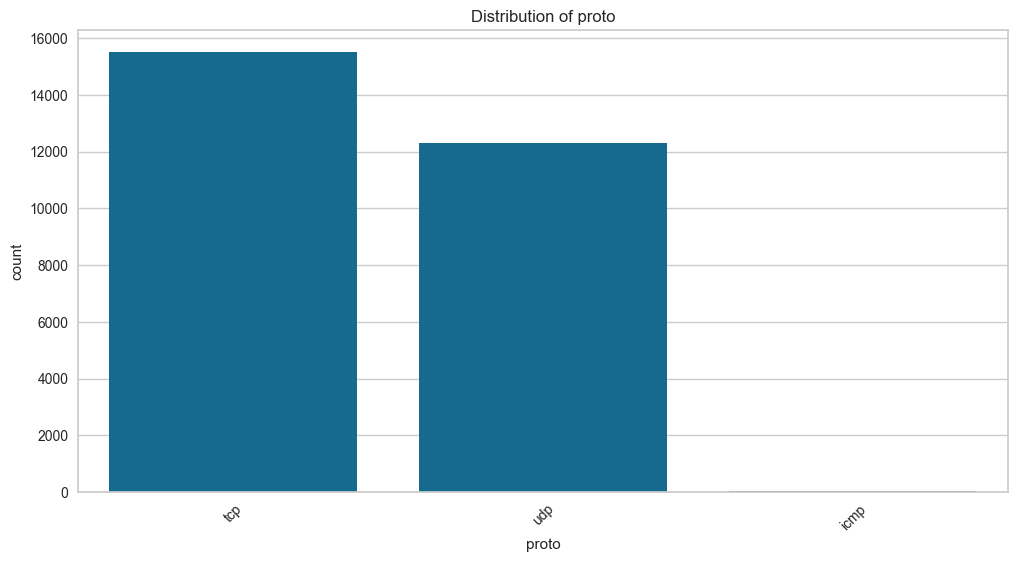

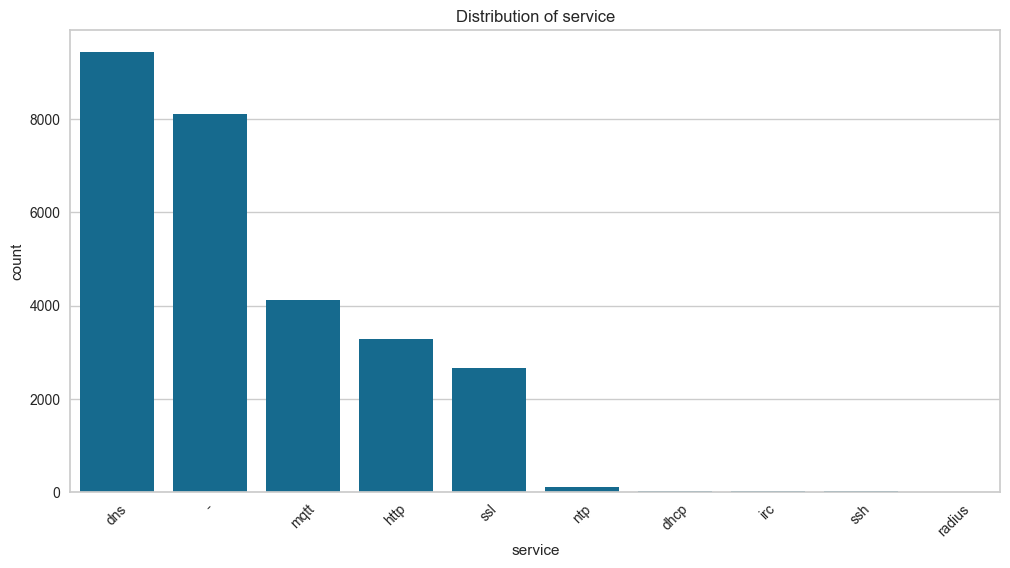

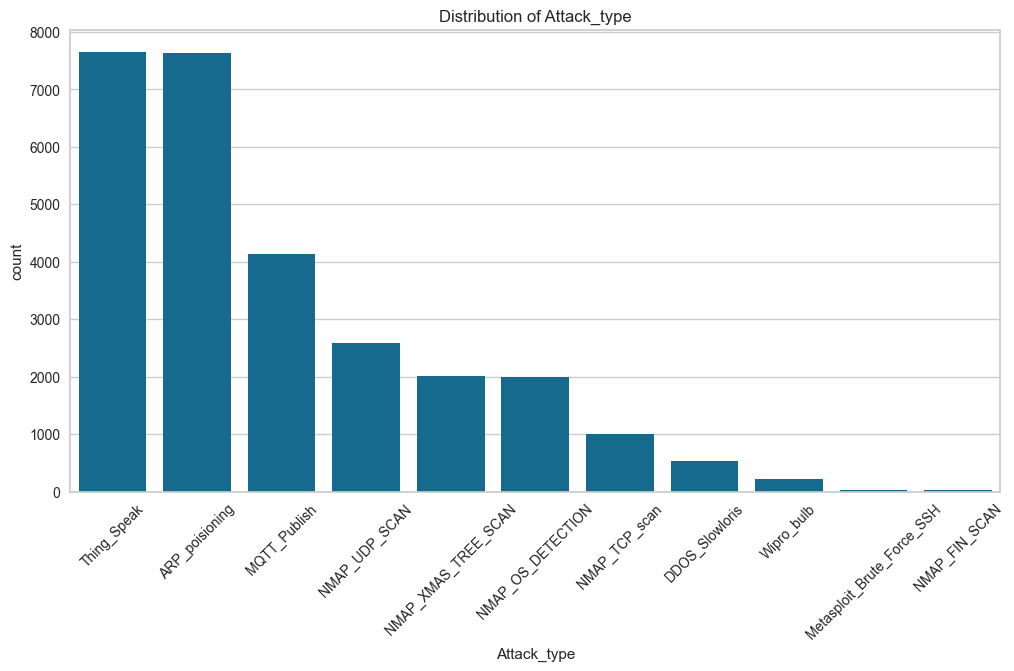

In [9]:
# Countplot for categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
for i in categorical_cols:
    plt.figure(figsize=(12,6))
    sns.countplot(x=df[i], data=df, order=df[i].value_counts().index)
    plt.title(f'Distribution of {i}')
    plt.xticks(rotation=45)
    plt.show()

In [10]:
# check for unique values for all columns
for col in df.columns:
    print(f'Unique values in {col}: {df[col].nunique()}')

# drop bwd_URG_flag_count due to single unique value
df.drop(columns=['bwd_URG_flag_count', 'fwd_URG_flag_count'], inplace=True)

Unique values in id.orig_p: 15230
Unique values in id.resp_p: 1809
Unique values in proto: 3
Unique values in service: 10
Unique values in flow_duration: 16380
Unique values in fwd_pkts_tot: 163
Unique values in bwd_pkts_tot: 172
Unique values in fwd_data_pkts_tot: 116
Unique values in bwd_data_pkts_tot: 154
Unique values in fwd_pkts_per_sec: 15886
Unique values in bwd_pkts_per_sec: 15423
Unique values in flow_pkts_per_sec: 16106
Unique values in down_up_ratio: 468
Unique values in fwd_header_size_tot: 353
Unique values in fwd_header_size_min: 7
Unique values in fwd_header_size_max: 8
Unique values in bwd_header_size_tot: 352
Unique values in bwd_header_size_min: 7
Unique values in bwd_header_size_max: 9
Unique values in flow_FIN_flag_count: 11
Unique values in flow_SYN_flag_count: 8
Unique values in flow_RST_flag_count: 9
Unique values in fwd_PSH_flag_count: 70
Unique values in bwd_PSH_flag_count: 98
Unique values in flow_ACK_flag_count: 210
Unique values in fwd_URG_flag_count: 2
Uniq

In [11]:
# values of service column
print(df['service'].value_counts())

service
dns       9444
-         8110
mqtt      4132
http      3289
ssl       2656
ntp        115
dhcp        29
irc         28
ssh         28
radius       2
Name: count, dtype: int64


In [12]:
# chi-square test for categorical feature 'service'
contingency_table = pd.crosstab(df['service'], df['Attack_type'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-square test p-value for service: {p}')
# since p < 0.05, we reject the null hypothesis and keep the feature
# then drop records with service value '-'
df = df[df['service'] != '-']
print(df.shape)

Chi-square test p-value for service: 0.0
(19723, 82)


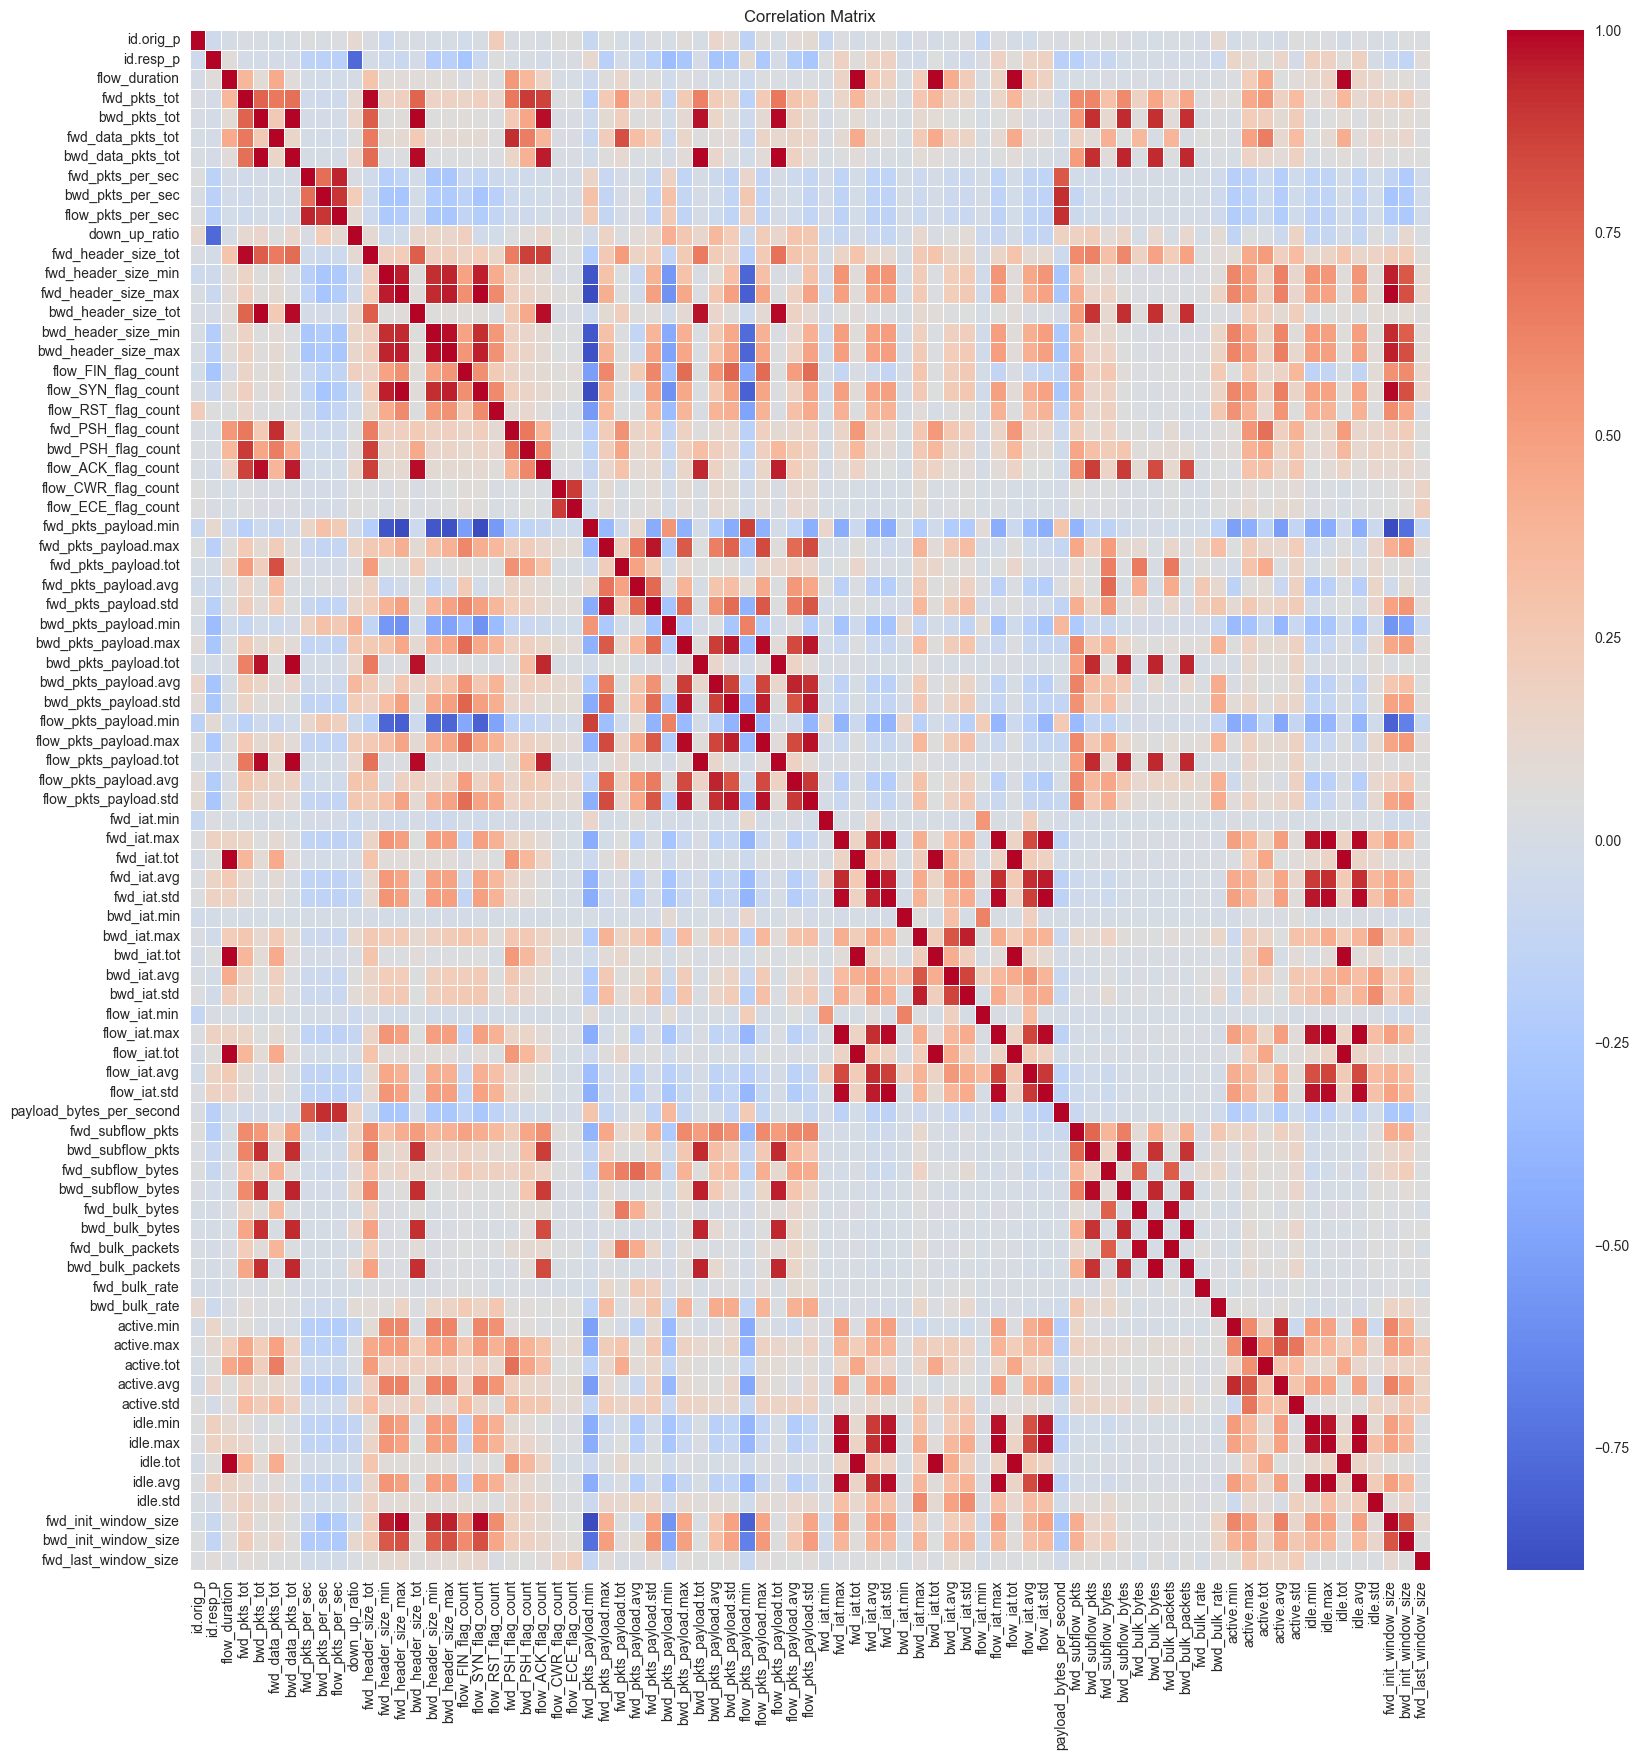

Columns to drop due to high correlation: ['bwd_data_pkts_tot', 'flow_pkts_per_sec', 'fwd_header_size_tot', 'fwd_header_size_max', 'bwd_header_size_tot', 'bwd_header_size_min', 'bwd_header_size_max', 'flow_SYN_flag_count', 'fwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_pkts_payload.min', 'fwd_pkts_payload.std', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.std', 'flow_pkts_payload.max', 'flow_pkts_payload.tot', 'flow_pkts_payload.avg', 'flow_pkts_payload.std', 'fwd_iat.tot', 'fwd_iat.avg', 'fwd_iat.std', 'bwd_iat.tot', 'bwd_iat.std', 'flow_iat.max', 'flow_iat.tot', 'flow_iat.avg', 'flow_iat.std', 'payload_bytes_per_second', 'bwd_subflow_pkts', 'bwd_subflow_bytes', 'bwd_bulk_bytes', 'fwd_bulk_packets', 'bwd_bulk_packets', 'active.avg', 'idle.min', 'idle.max', 'idle.tot', 'idle.avg', 'fwd_init_window_size']


In [13]:
# correlation matrix
numerical_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(20,20))
corr = numerical_df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Detect highly correlated features with threshold of 0.9 and drop one of each pair
th = 0.9
corr_matrix = numerical_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > th)]
print(f'Columns to drop due to high correlation: {to_drop}')

(19723, 43)


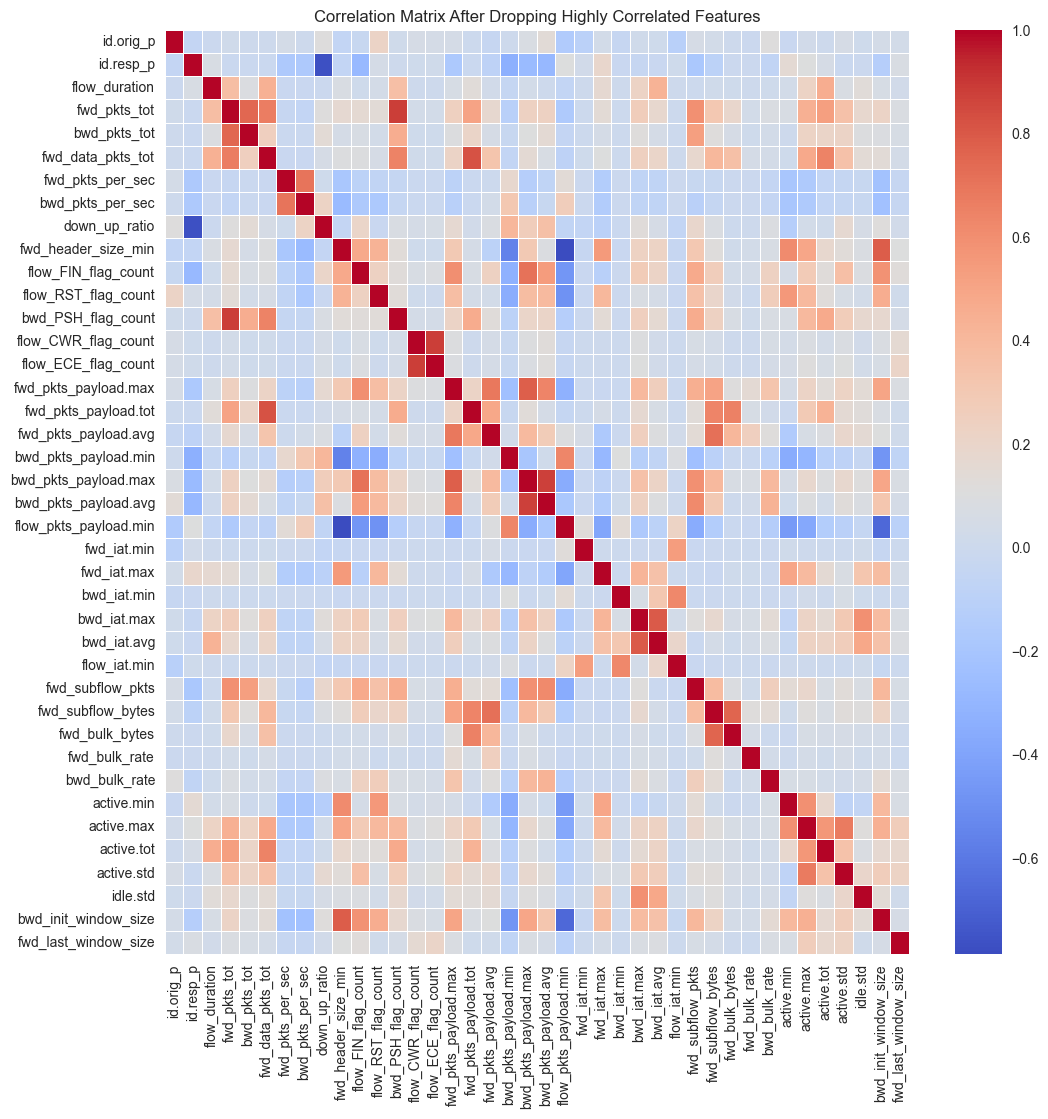

In [14]:
# Dimension reduction
# drop one of highly correlated feature pairs (threshold = 0.9)
df.drop(columns=to_drop, inplace=True)

# check new shape after dropping
print(df.shape)

# check correlation matrix again
plt.figure(figsize=(12,12))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix After Dropping Highly Correlated Features')
plt.show()

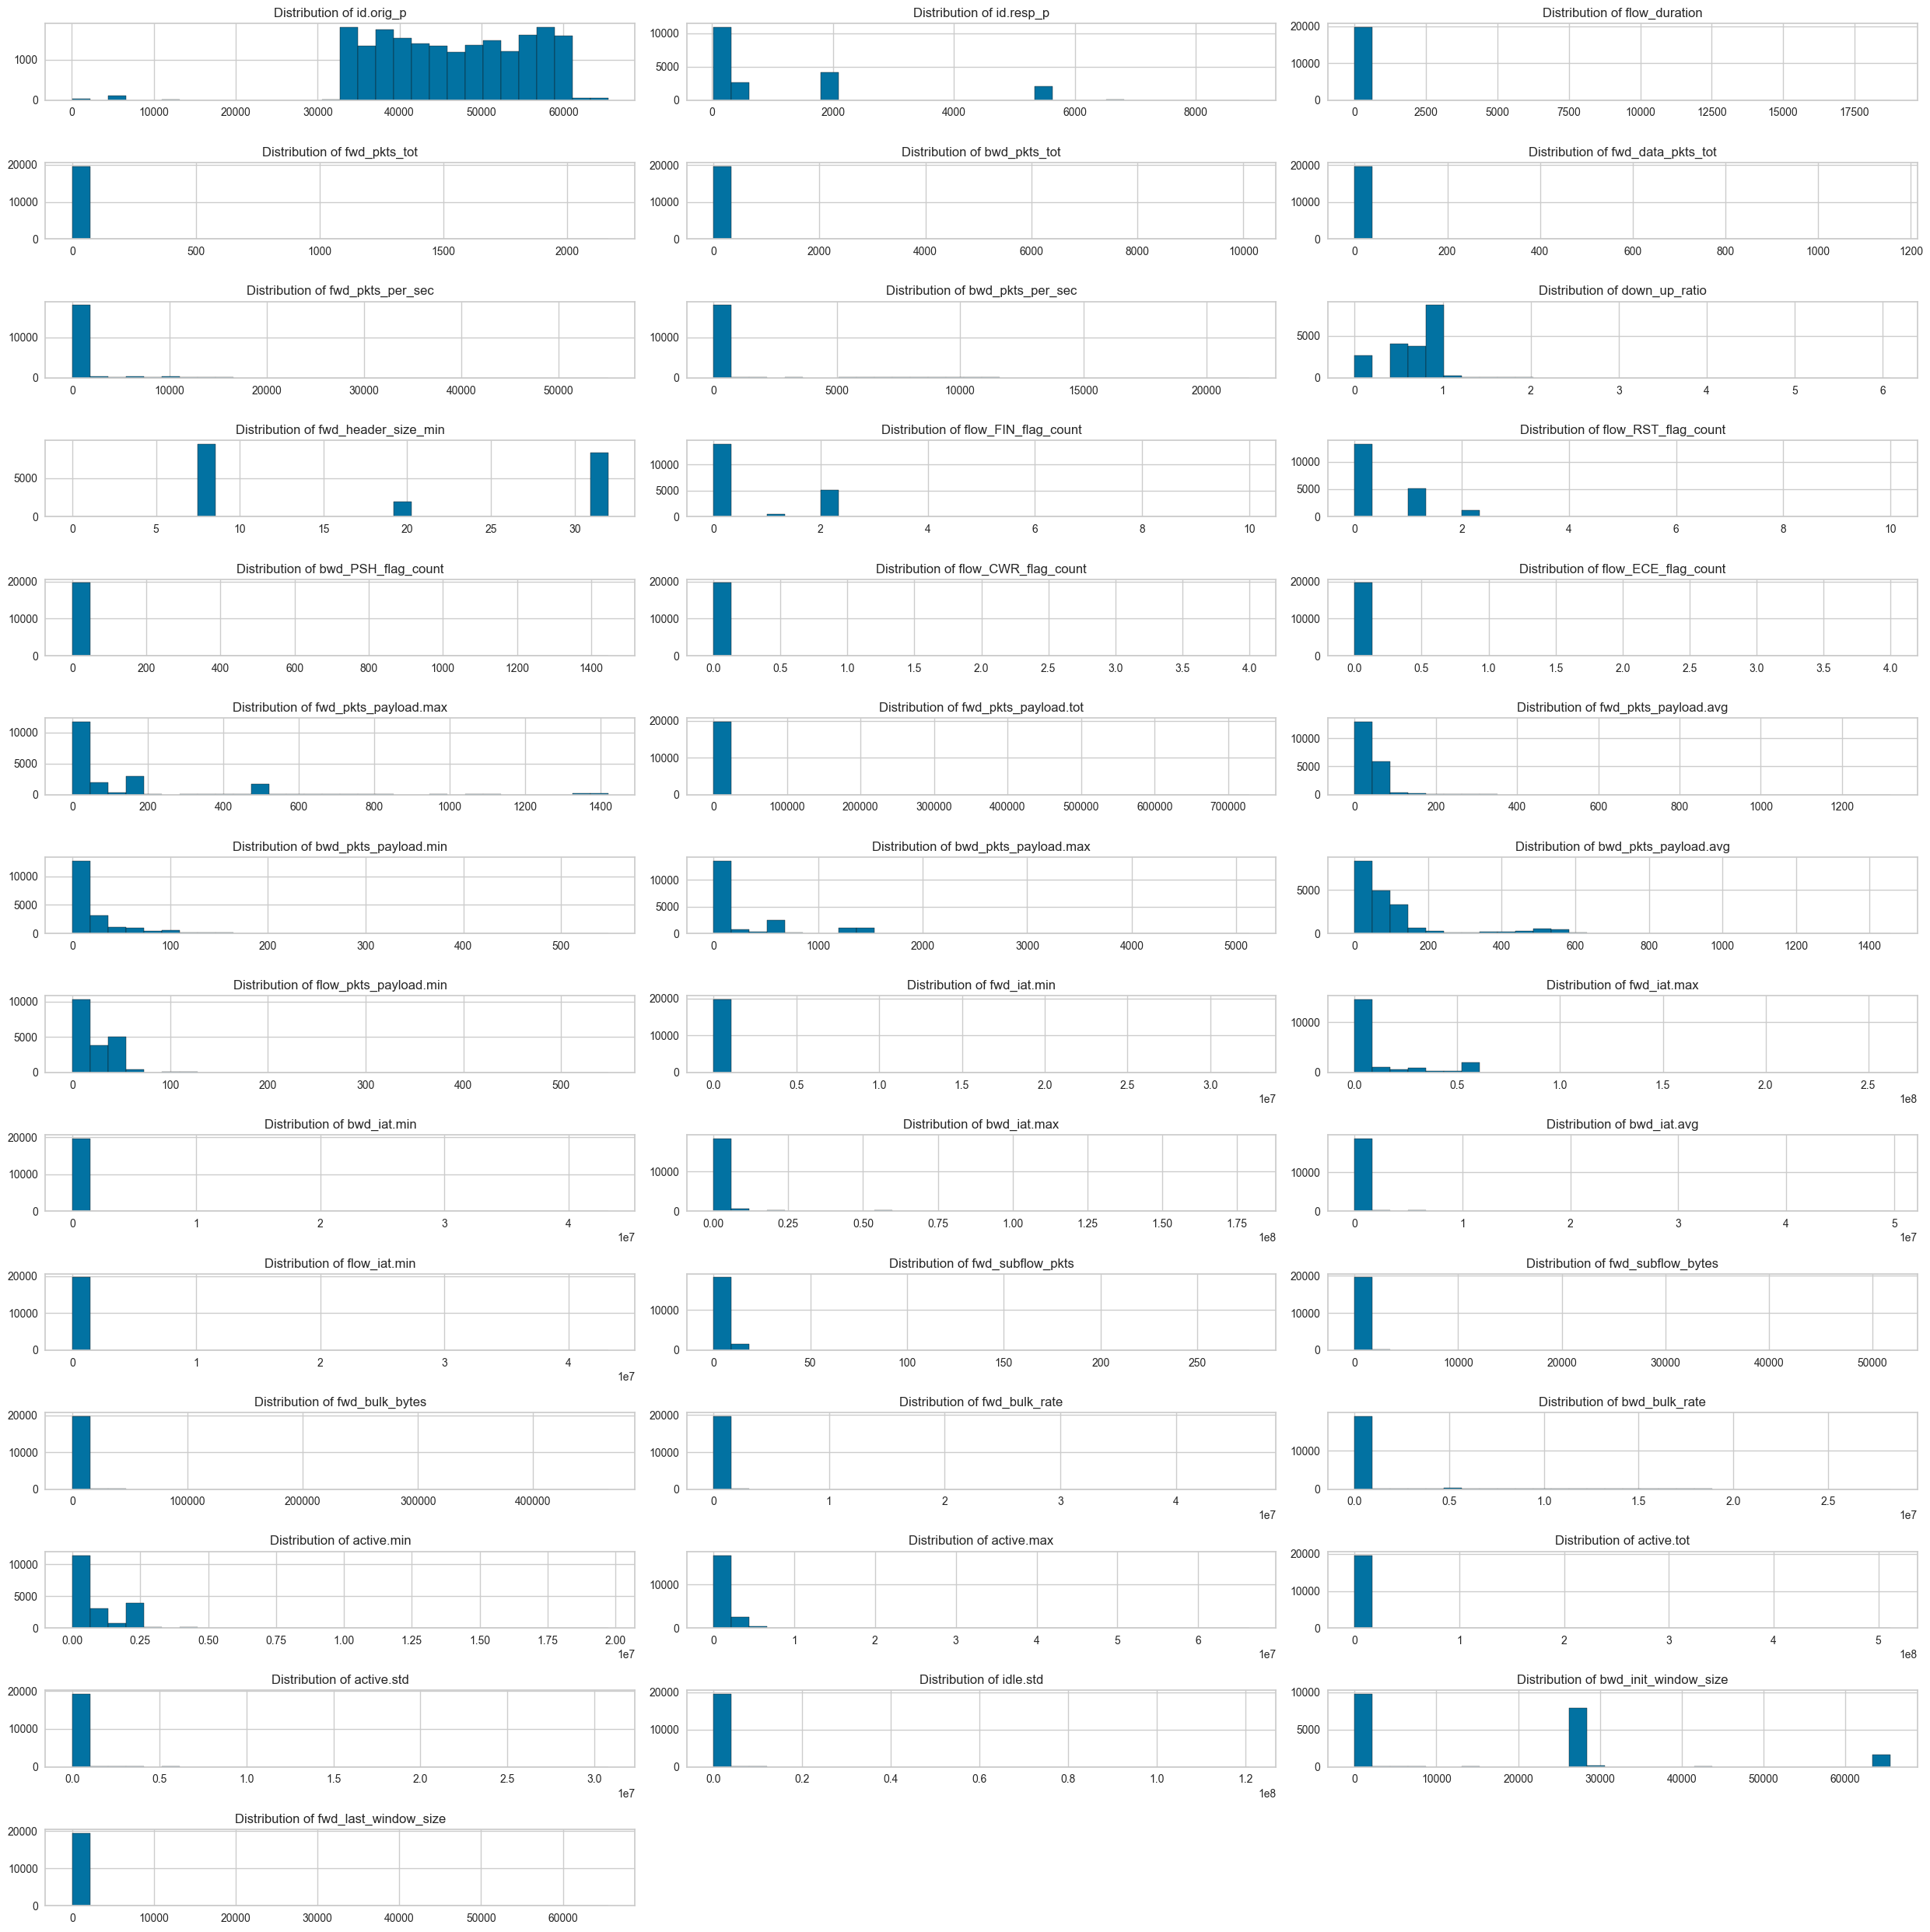

In [15]:
# Histograms for numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns
f = plt.figure(figsize=(25, 25))
for i,col in enumerate(numerical_cols):
    ax = f.add_subplot((len(numerical_cols) + 2) // 3, 3, i + 1)
    plt.hist(df[col], bins=30, edgecolor='k')
    ax.set_title(f'Distribution of {col}')
plt.tight_layout()

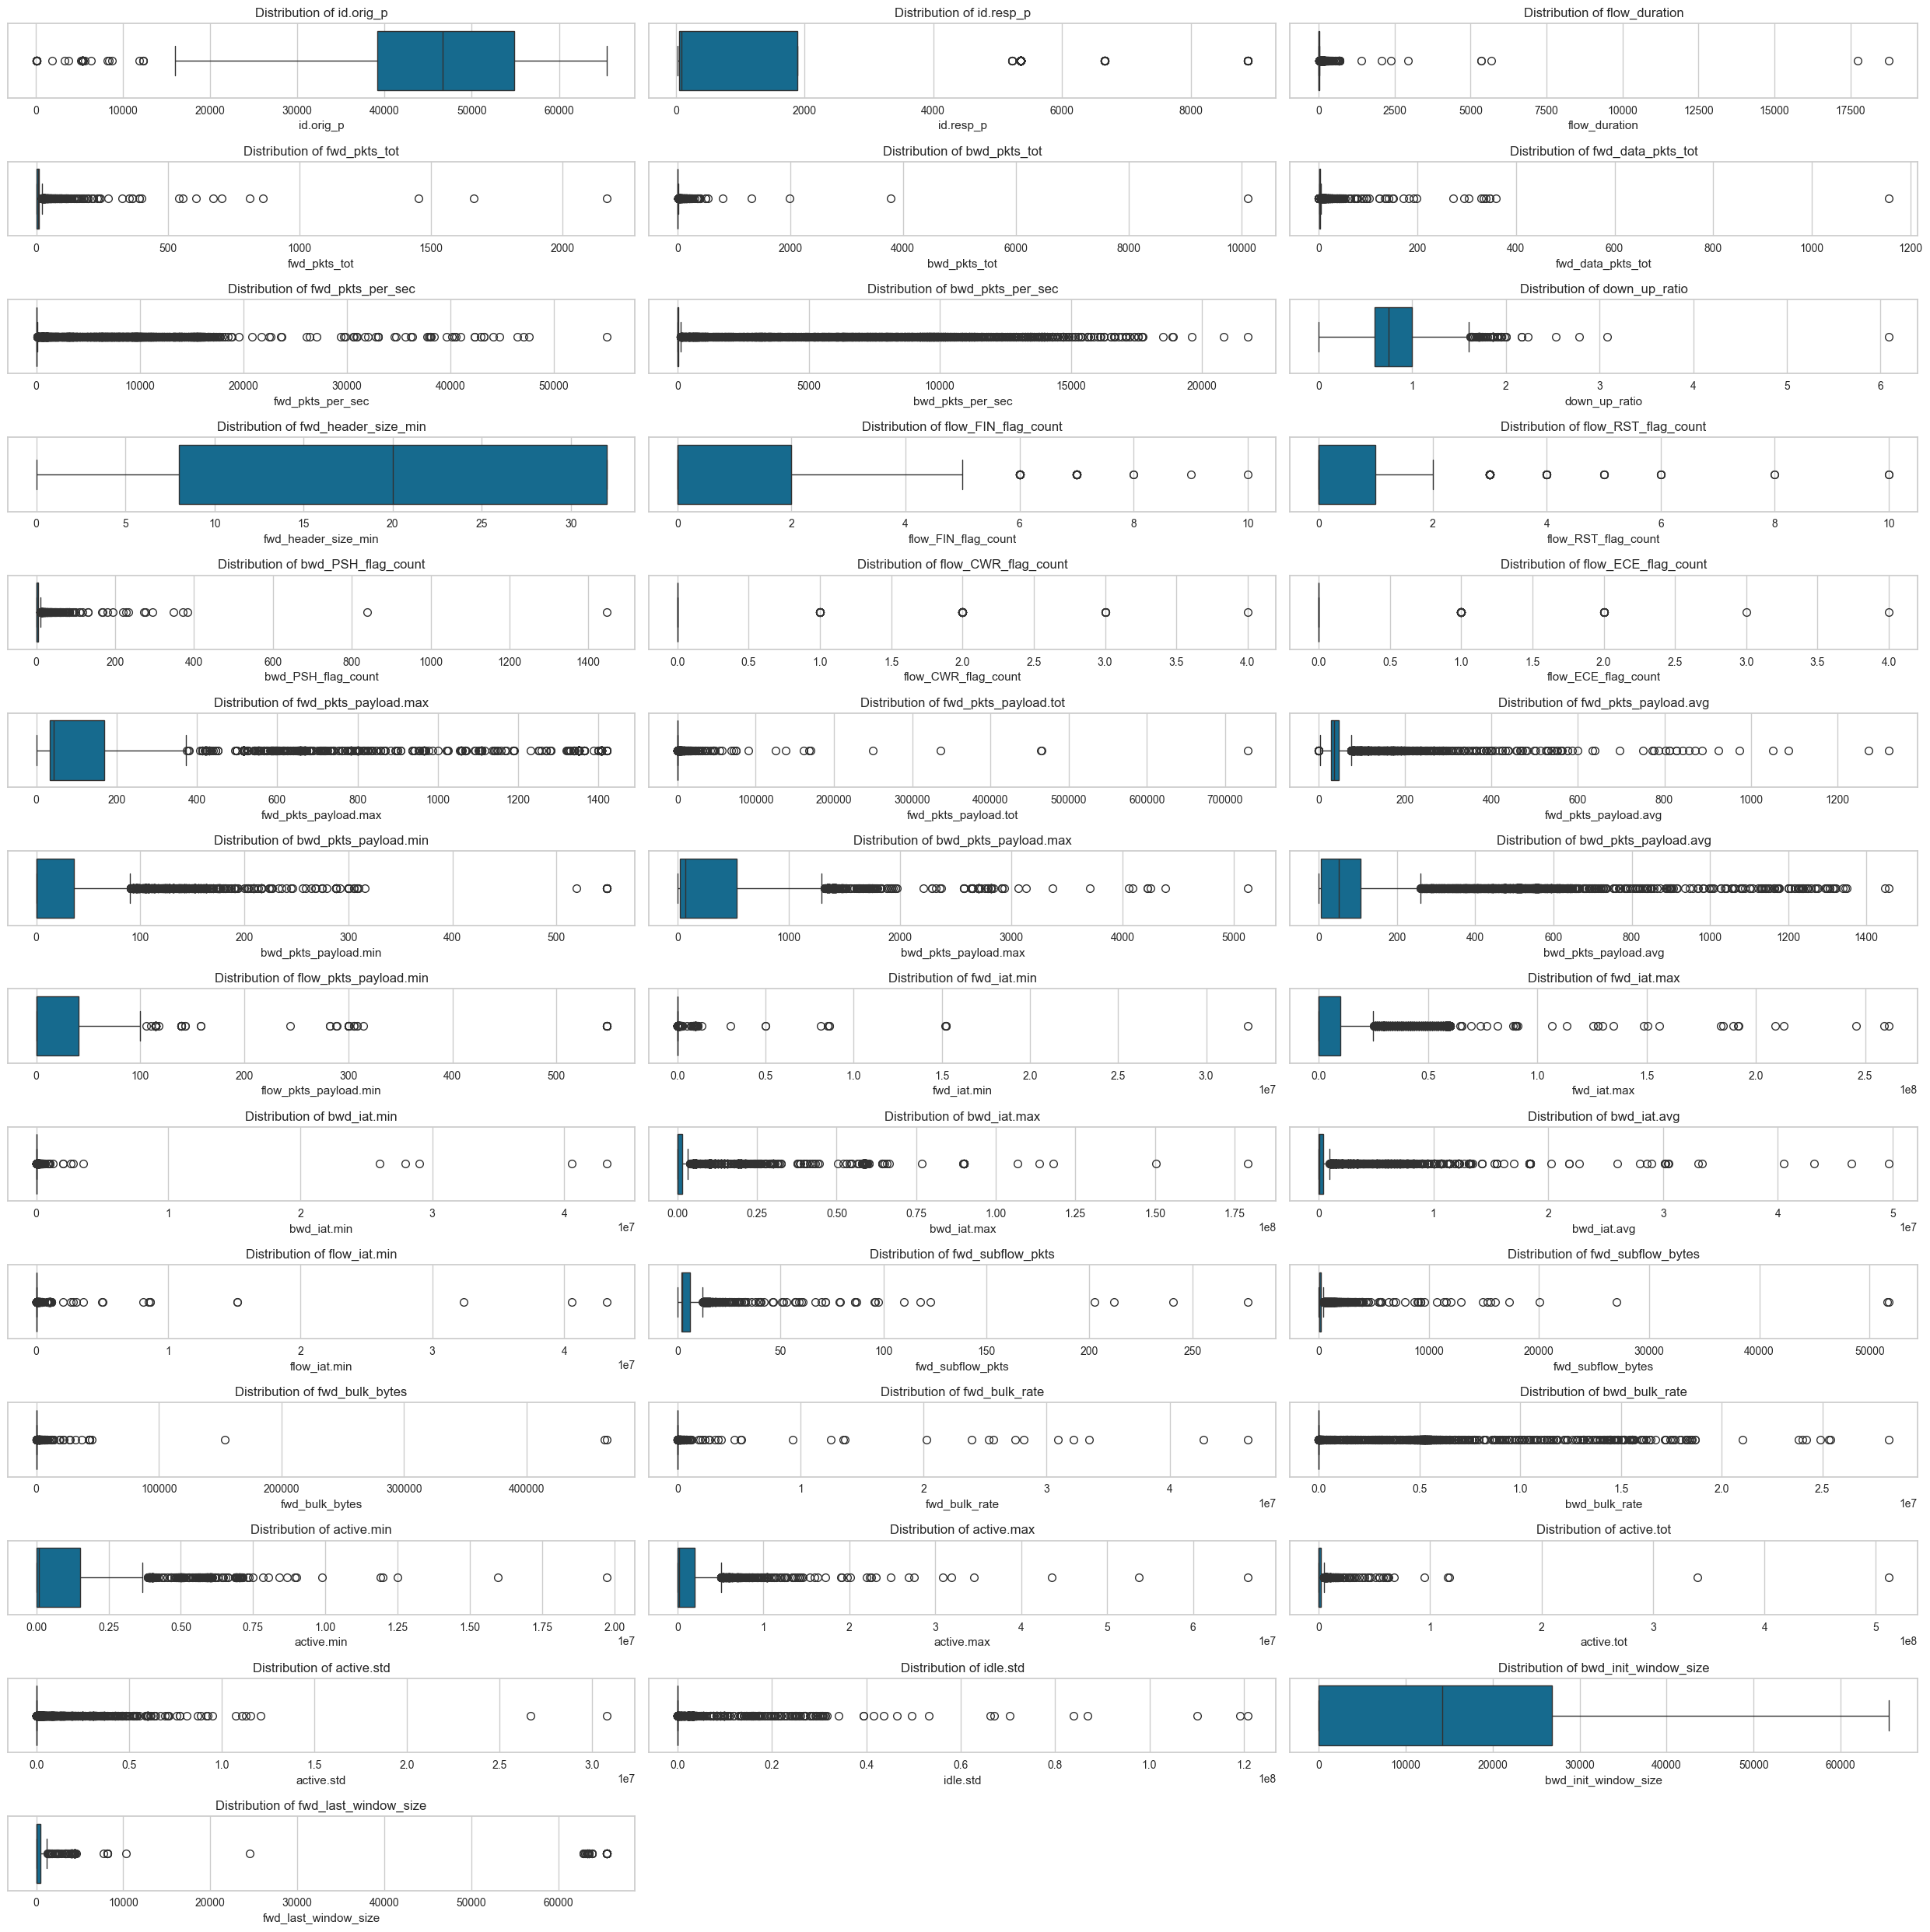

In [16]:
# Boxplots for numerical features
f = plt.figure(figsize=(25, 25))
for i,col in enumerate(numerical_cols):
    ax = f.add_subplot((len(numerical_cols) + 2) // 3, 3, i + 1)
    sns.boxplot(orientation='h', x=df[col])
    ax.set_title(f'Distribution of {col}')
plt.tight_layout()

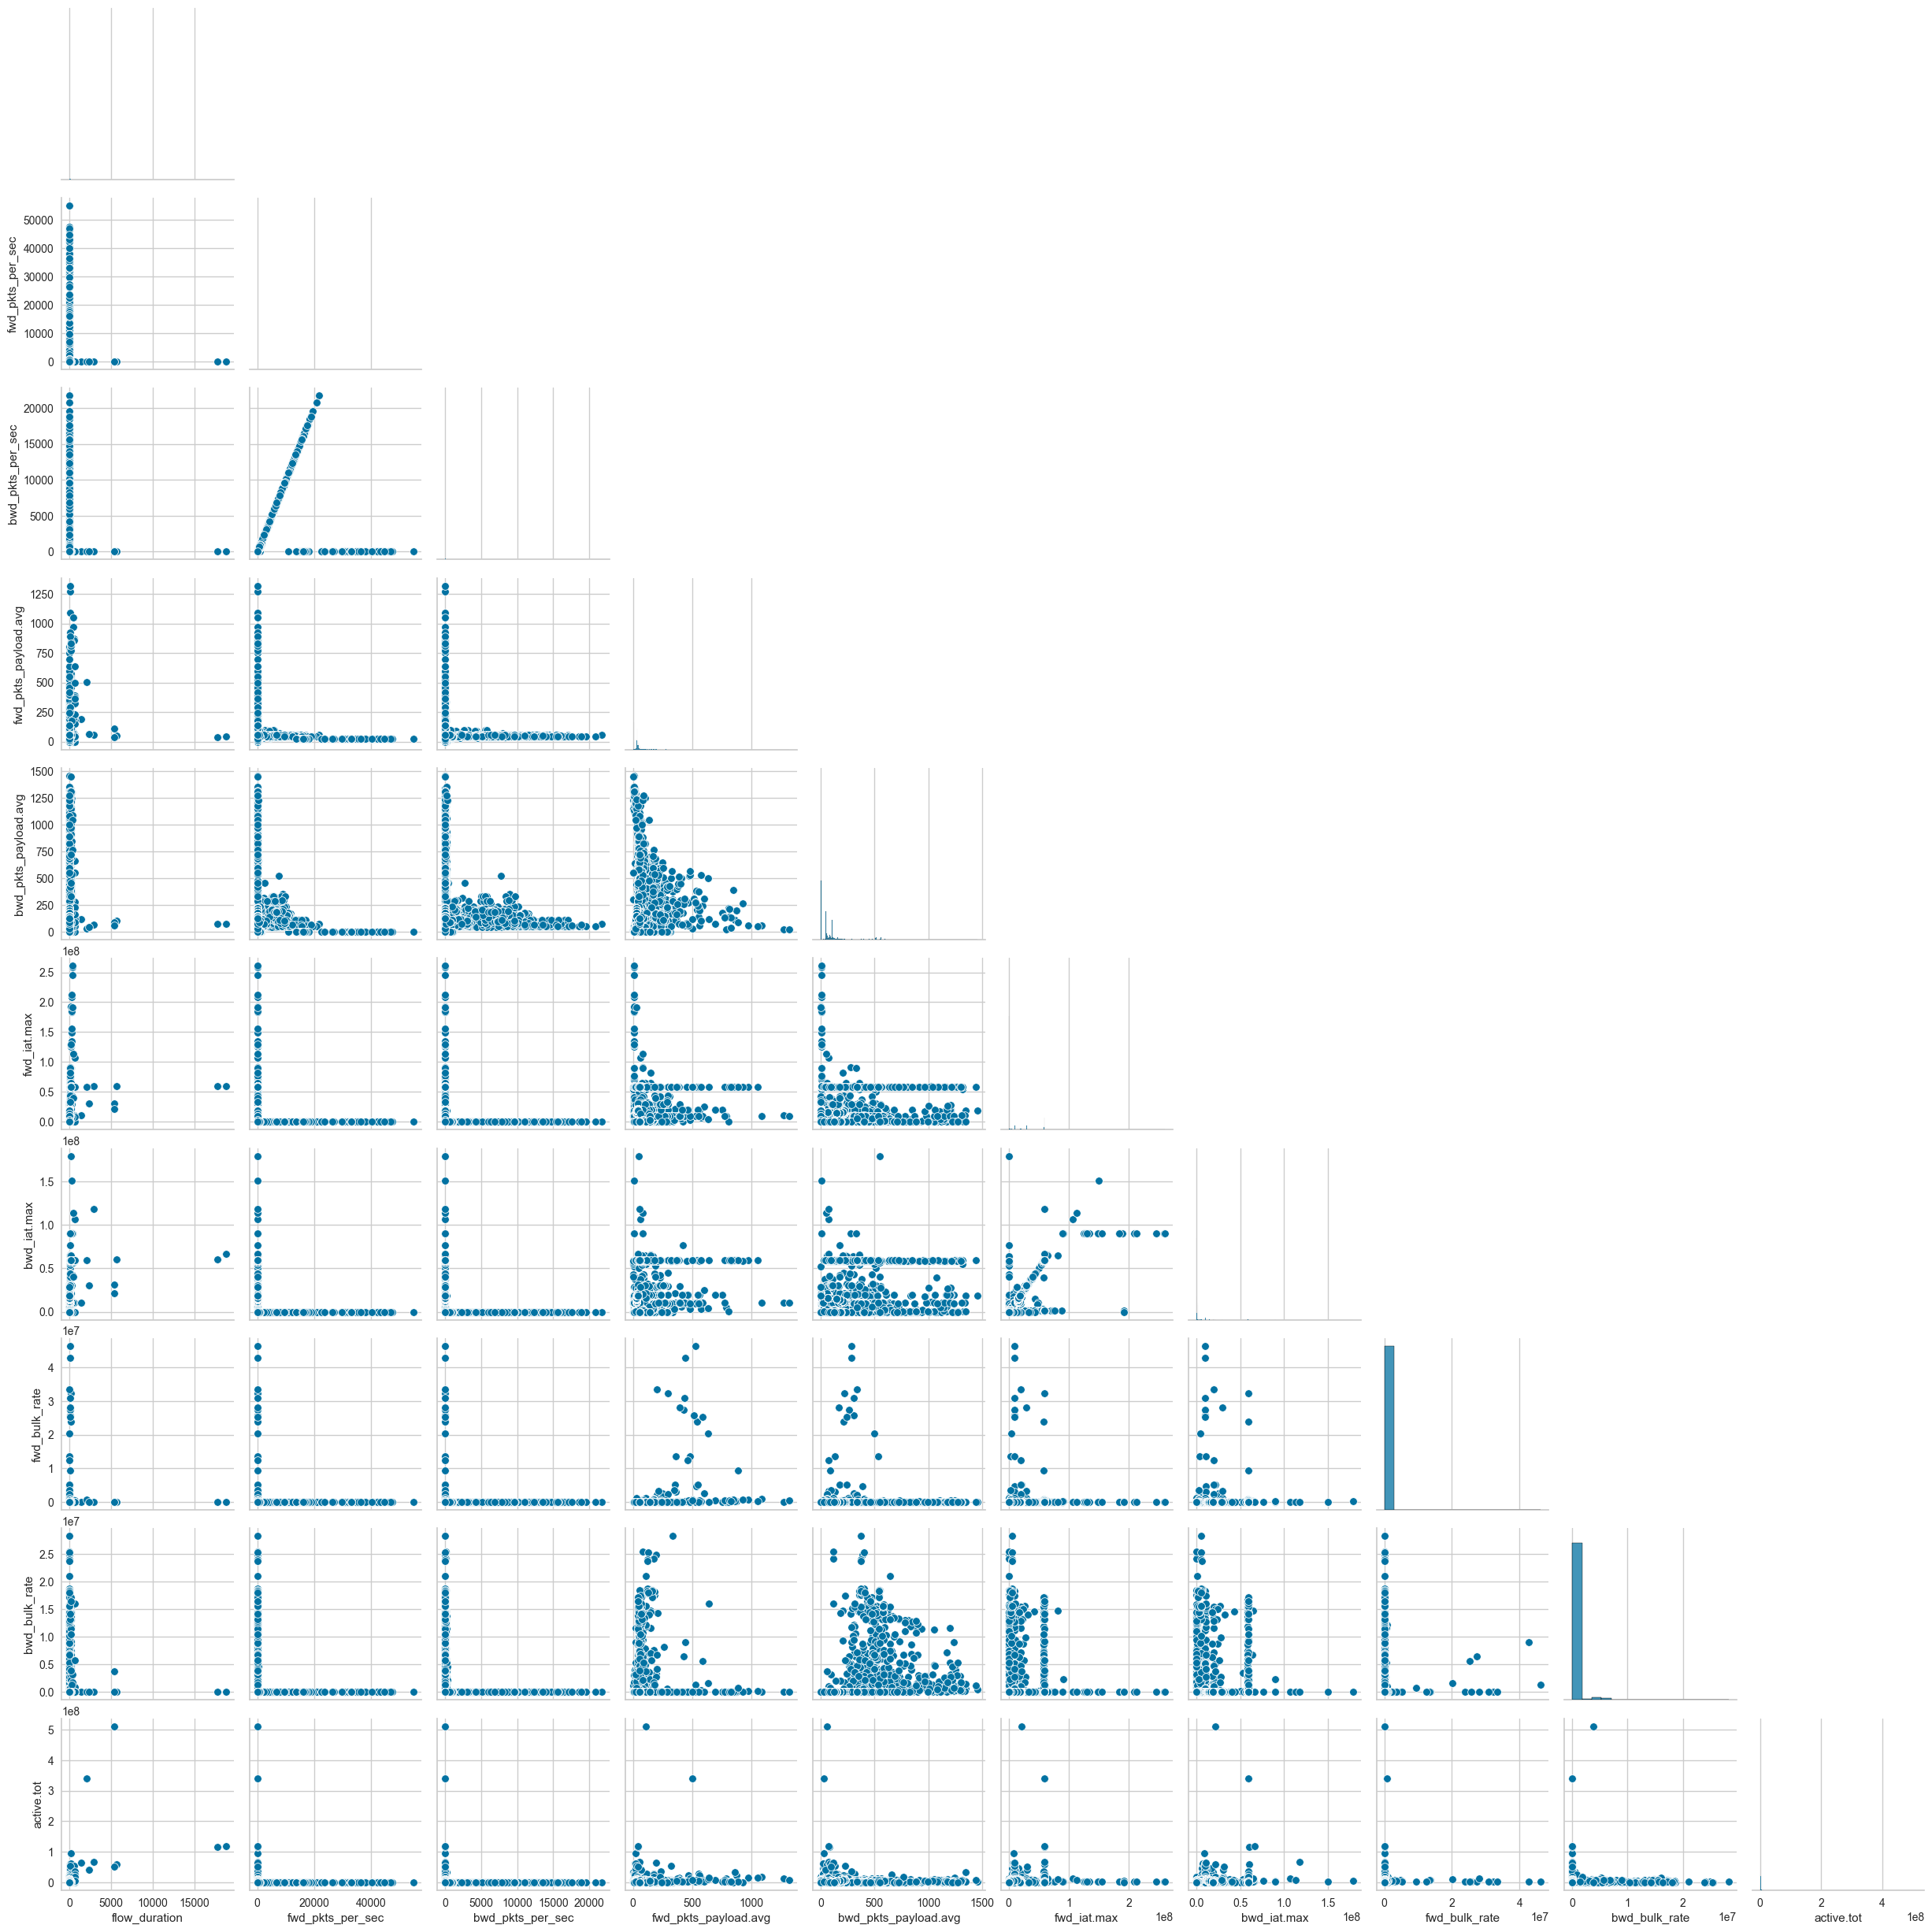

In [17]:
# Pairplot or scatterplot 
# Due to large number of features, we will plot a sample of 5 numerical features
numerical_cols.tolist()
sampled_cols = ['flow_duration', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec', 'fwd_pkts_payload.avg', 'bwd_pkts_payload.avg', 'fwd_iat.max', 'bwd_iat.max', 'fwd_bulk_rate', 'bwd_bulk_rate', 'active.tot']
# Use scatter plots instead of KDE to avoid errors
sns.pairplot(df[sampled_cols + ['Attack_type']], corner=True)
plt.show()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19723 entries, 0 to 26451
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id.orig_p              19723 non-null  int64  
 1   id.resp_p              19723 non-null  int64  
 2   proto                  19723 non-null  object 
 3   service                19723 non-null  object 
 4   flow_duration          19723 non-null  float64
 5   fwd_pkts_tot           19723 non-null  int64  
 6   bwd_pkts_tot           19723 non-null  int64  
 7   fwd_data_pkts_tot      19723 non-null  int64  
 8   fwd_pkts_per_sec       19723 non-null  float64
 9   bwd_pkts_per_sec       19723 non-null  float64
 10  down_up_ratio          19723 non-null  float64
 11  fwd_header_size_min    19723 non-null  int64  
 12  flow_FIN_flag_count    19723 non-null  int64  
 13  flow_RST_flag_count    19723 non-null  int64  
 14  bwd_PSH_flag_count     19723 non-null  int64  
 15  flow_CW

# Part 3: Implementing Classification Algorithms
- Three Classification Models to be implemented: Random Forest Classifier, Logistic Regression, and Support Vector Machine (SVM)

In [19]:
# Encoding categorical variables and preparing data for modeling
# Seperate features and target variable
X = df.drop(columns=['Attack_type'])
y = df['Attack_type']

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(y)

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)
X = X.astype(np.float32)
print(X.shape)
X.head()

(19723, 49)


id.orig_p  id.resp_p  flow_duration  fwd_pkts_tot  bwd_pkts_tot  \
0    38667.0     1883.0      32.011597           9.0           5.0   
1    51143.0     1883.0      31.883583           9.0           5.0   
2    44761.0     1883.0      32.124054           9.0           5.0   
3    60893.0     1883.0      31.961063           9.0           5.0   
4    51087.0     1883.0      31.902363           9.0           5.0   

   fwd_data_pkts_tot  fwd_pkts_per_sec  bwd_pkts_per_sec  down_up_ratio  \
0                3.0          0.281148          0.156193       0.555556   
1                3.0          0.282277          0.156821       0.555556   
2                3.0          0.280164          0.155647       0.555556   
3                3.0          0.281593          0.156440       0.555556   
4                3.0          0.282111          0.156728       0.555556   

   fwd_header_size_min  ...  fwd_last_window_size  proto_udp  service_dns  \
0                 32.0  ...                 502.0        0.0          0.0   
1                 32.0  ...                 502.0        0.0          0.0   
2                 32.0  ...                 502.0        0.0          0.0   
3                 32.0  ...                 502.0        0.0          0.0   
4                 32.0  ...                 502.0        0.0          0.0   

   service_http  service_irc  service_mqtt  service_ntp  service_radius  \
0           0.0          0.0           1.0          0.0             0.0   
1           0.0          0.0           1.0          0.0             0.0   
2           0.0          0.0           1.0          0.0             0.0   
3           0.0          0.0           1.0          0.0             0.0   
4           0.0          0.0           1.0          0.0             0.0   

   service_ssh  service_ssl  
0          0.0          0.0  
1          0.0          0.0  
2          0.0          0.0  
3          0.0          0.0  
4          0.0          0.0  

[5 rows x 49 columns]

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Z-score normalization due to keeping outliers and wide range of values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)
X_robust = RobustScaler().fit_transform(X) 

Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1418
           1       1.00      1.00      1.00       104
           2       1.00      1.00      1.00       815
           3       1.00      0.75      0.86         4
           4       0.00      0.00      0.00         2
           5       0.93      0.84      0.88        31
           6       0.00      0.00      0.00         1
           7       0.99      0.99      0.99      1521
           8       0.98      0.94      0.96        49

    accuracy                           0.99      3945
   macro avg       0.77      0.72      0.74      3945
weighted avg       0.99      0.99      0.99      3945



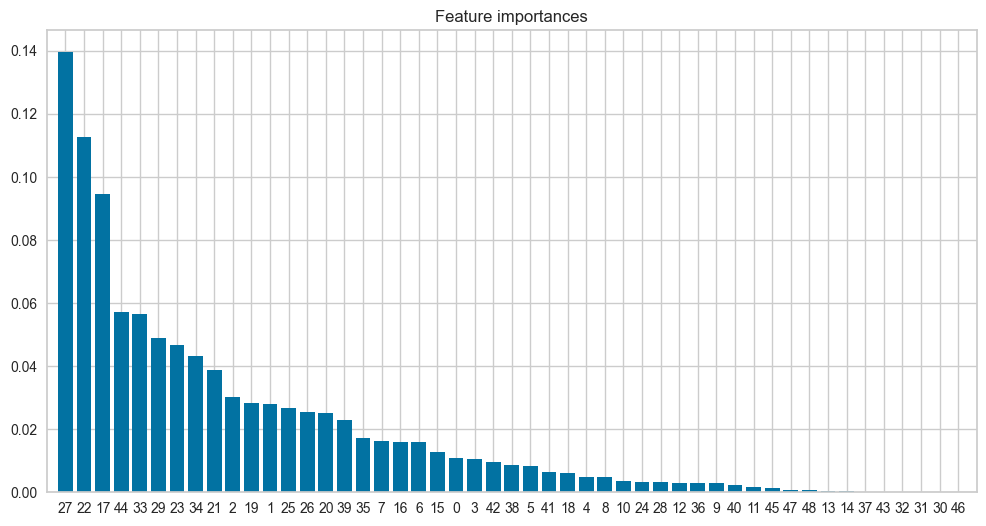

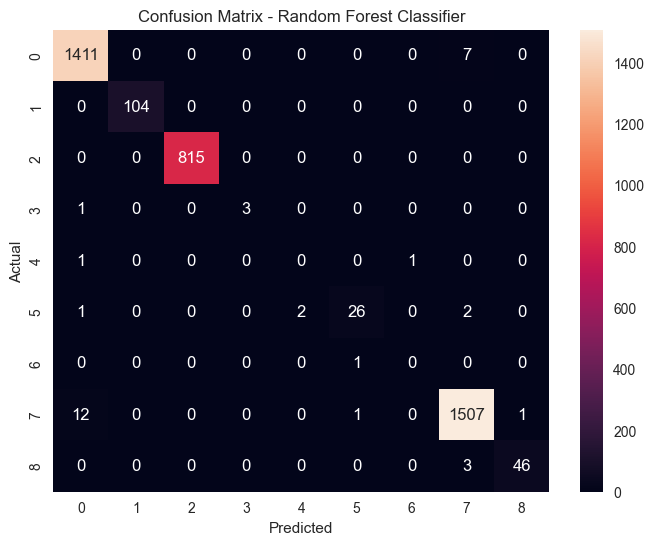

In [21]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred_rfc))

# Feature importance from Random Forest
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Confusion Matrix for Random Forest
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rfc, annot=True, fmt='d')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Observations on Random Forest Classifier:
- According to the results, Random Forest Classifier performs well on this dataset. 
- Further hyperparameter tuning and model comparisons can be done for optimization.
- And according to feature importance plot, we can say no single feature dominates the prediction,
- so we can keep all features for further modeling

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1418
           1       0.95      0.83      0.88       104
           2       1.00      1.00      1.00       815
           3       1.00      0.75      0.86         4
           4       0.00      0.00      0.00         2
           5       0.57      0.77      0.66        31
           6       0.00      0.00      0.00         1
           7       0.92      0.96      0.94      1521
           8       0.93      0.76      0.83        49

    accuracy                           0.94      3945
   macro avg       0.70      0.66      0.68      3945
weighted avg       0.94      0.94      0.94      3945



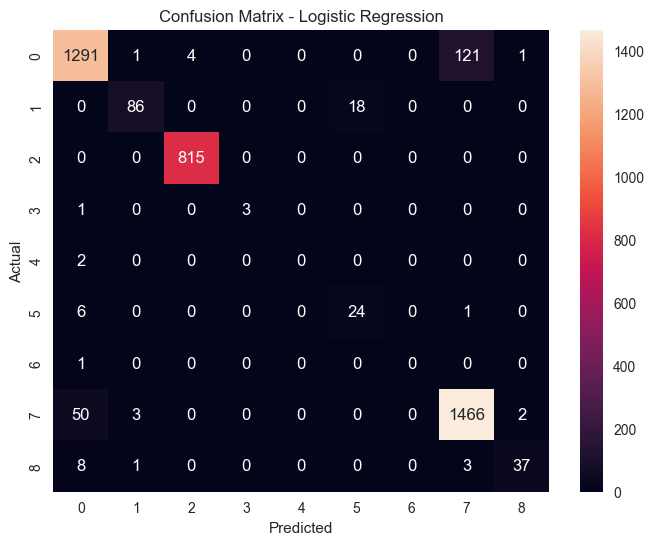

In [22]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0))

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8,6))
sns.heatmap(cm_lr, annot=True, fmt='d')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Observations on Logistic Regressin Classifier:
- According to result Logistic Regression performs well too but slightly worse than Random Forest
- Especially in minority classes Logistic Regression has lower recall and precision score
- The reson behind this result could be the complex relationships and interactions between features that Random Forest can capture better than Logistic Regression.

Support Vector Machine Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1418
           1       0.98      0.83      0.90       104
           2       1.00      1.00      1.00       815
           3       1.00      0.75      0.86         4
           4       0.00      0.00      0.00         2
           5       0.57      0.77      0.66        31
           6       0.00      0.00      0.00         1
           7       0.98      0.96      0.97      1521
           8       1.00      0.63      0.78        49

    accuracy                           0.97      3945
   macro avg       0.72      0.66      0.68      3945
weighted avg       0.97      0.97      0.97      3945



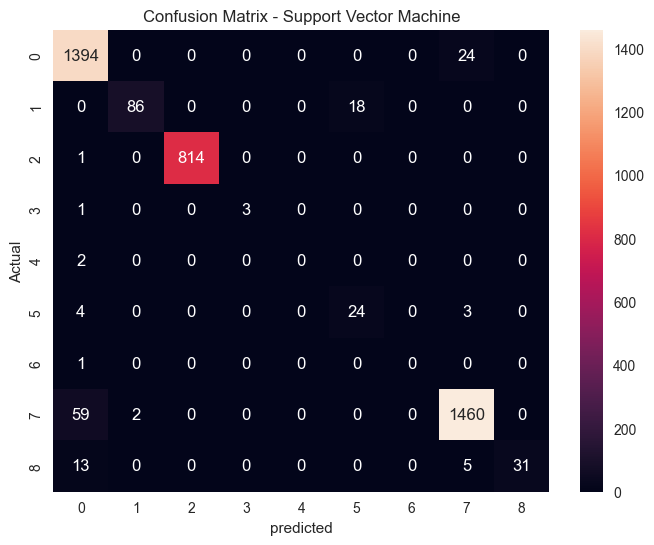

In [23]:
# Support Vector Machine (SVM)
svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
print("Support Vector Machine Report:")
print(classification_report(y_test, svm_pred, zero_division=0))

# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, svm_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_svm, annot=True, fmt='d')
plt.title('Confusion Matrix - Support Vector Machine')
plt.xlabel('predicted')
plt.ylabel('Actual')
plt.show()

# Observations on Support Vector Machine Classifier:
- According to results, SVM performed better than Logistic Regression but worse than Random Forest Classifier.
- Again especially in minority classes, RFC performed significantly better.
- Further hyperparameter tuning and cross-validation can be performed to improve model performance.
- The reason behind this result could be the complex nature of dataset and ability of RFC to handle high dimensional data and capture complex patterns.

# Part 4: Implementing Clustering Algorithms
- Three Clustering Algorithms to be implemented: K-Means, DBSCAN and Agglomerative(Hierarchical) Clustering

4.1: Clustering Algorithms Before Outlier Removal

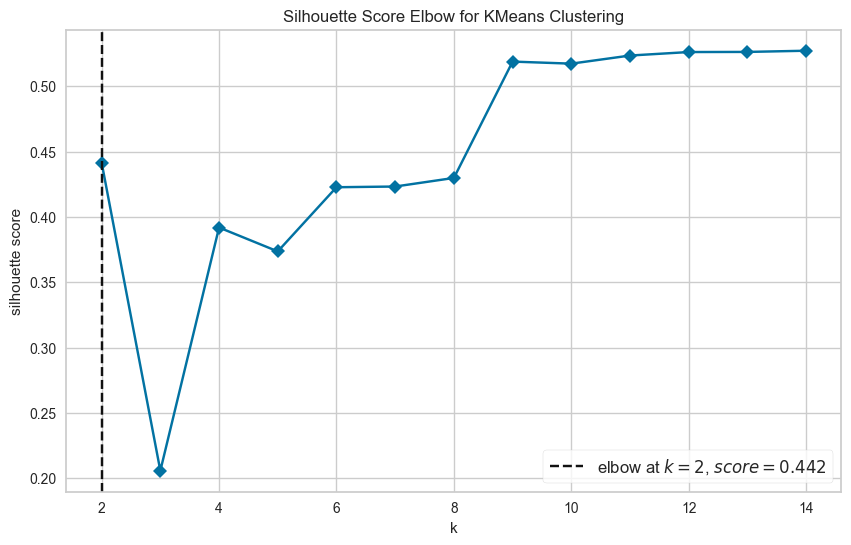

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [76]:
# Find optimal k for K-Means
plt.figure(figsize=(10,6))
model = KMeans(random_state=42)

# Try k from 2 to 15
visualizer = KElbowVisualizer(model, k=(2,15), metric='silhouette', timings=False)
visualizer.fit(X_scaled)        
visualizer.show()

In [ ]:
# Visualizing K-Means Clusters using first two principal components
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# t-SNE visualization instead of PCA for better cluster visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_scaled)

K-Means Silhouette Score:
0.44157627


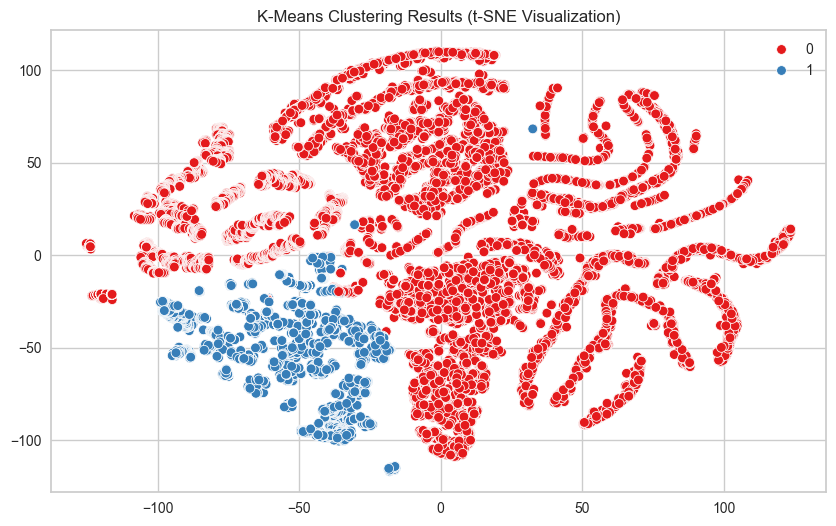

In [78]:
# K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled) # fit on robust scaled data because of outliers and better performance
kmeans_labels = kmeans.labels_
print("K-Means Silhouette Score:")
print(silhouette_score(X_scaled, kmeans_labels))


plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=kmeans_labels, palette='Set1', legend='full')
plt.title('K-Means Clustering Results (t-SNE Visualization)')
plt.show()

# Observations on K-Means Clustering:
- First I used PCA for visulization but t-SNE gives better separation I will add an example of PCA plot too end of this section
- According to plot K-Means is not able to seperate clusters well
- The reason could be presence of outliers and non-spherical clusters
- DBSCAN clustering can be more effective in such cases

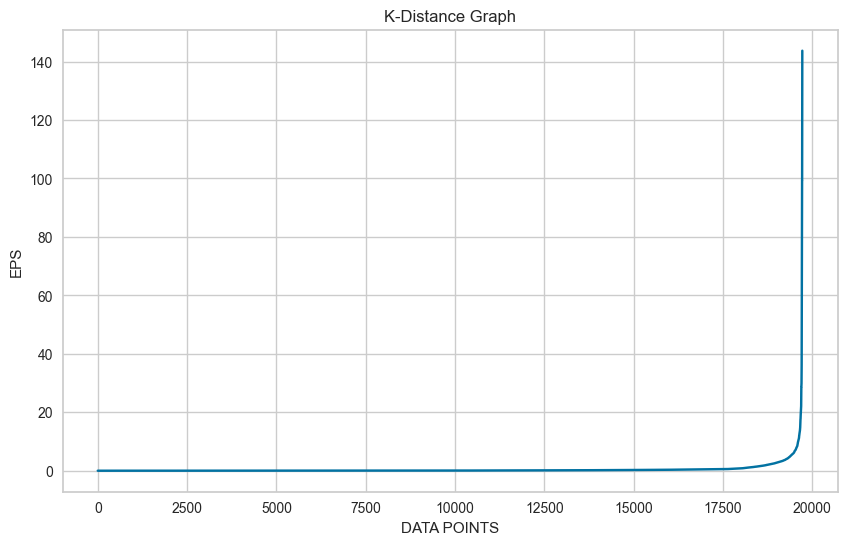

In [26]:
# K-distance to find eps
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)
kdist= sorted(distances[:, k-1], reverse=False)

# Graph for K-distance
plt.figure(figsize=(10, 6))
plt.plot(kdist)
plt.title('K-Distance Graph')
plt.ylabel('EPS')
plt.xlabel('DATA POINTS')
plt.grid(True)
plt.show()

DBSCAN Silhouette Score:
0.4957914


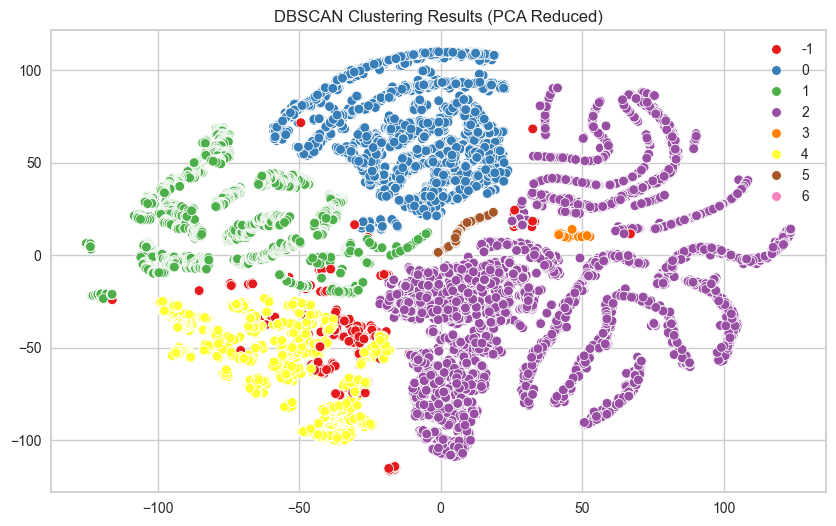

Number of noise points in DBSCAN: 476


In [80]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=4, min_samples=10)
dbscan.fit(X_scaled)

dbscan_labels = dbscan.labels_
print("DBSCAN Silhouette Score:")
print(silhouette_score(X_scaled, dbscan_labels))

# Visualizing DBSCAN Clusters using first two principal components
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=dbscan_labels, palette='Set1', legend='full')
plt.title('DBSCAN Clustering Results (PCA Reduced)')
plt.show()

# Number of label -1 points in DBSCAN
print(f'Number of noise points in DBSCAN: {(dbscan_labels == -1).sum()}')

# Observations on DBSCAN Clustering:
- I tried plot for find optimal eps value for DBSCAN then I tried different eps value 2-5 and 4 gave best performance
- DBSCAN found too many noise points with -1 label (476),
- But silhouette score is still acceptable and slightly better than K-Means
- Again presence of outlilers might be affecting the clustering results

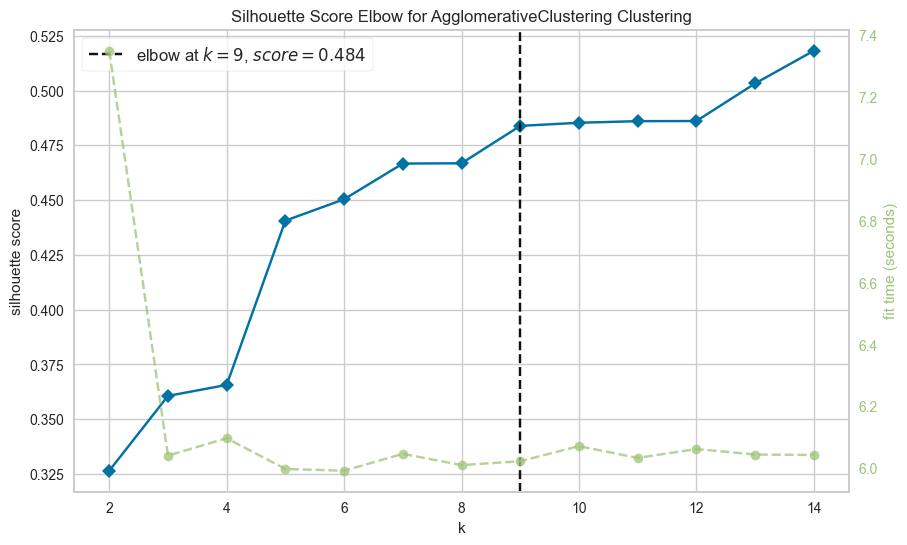

<Axes: title={'center': 'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [66]:
# Find n_clusters for Agglomerative Clustering 
plt.figure(figsize=(10,6))
model = AgglomerativeClustering()

visualizer = KElbowVisualizer(model, k=(2,15), metric='silhouette', timing=False)
visualizer.fit(X_scaled)
visualizer.show()

Agglomerative Clustering Silhouette Score: 
0.44060764


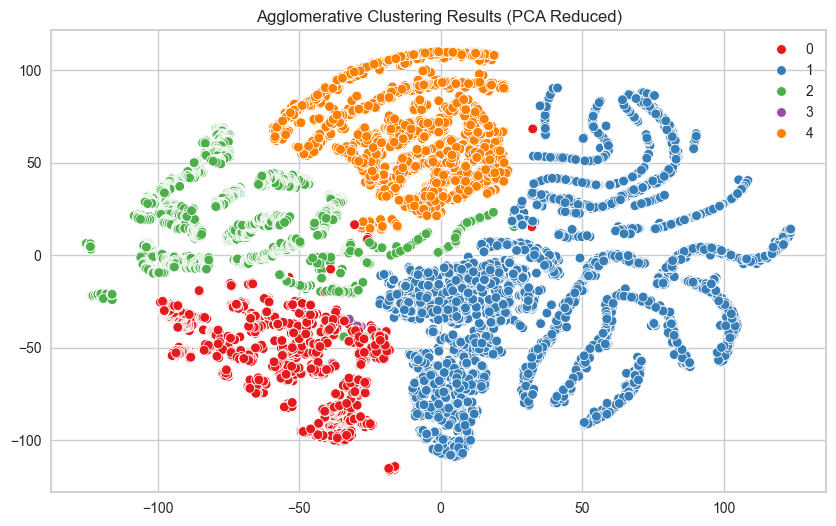

In [72]:
# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=5)
agglo_labels = agglo.fit_predict(X_scaled)

print('Agglomerative Clustering Silhouette Score: ')
print(silhouette_score(X_scaled, agglo_labels))

# Visualizing Agglomerative Clusters using first two principal components
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=agglo_labels, palette='Set1', legend='full')
plt.title('Agglomerative Clustering Results (PCA Reduced)')
plt.show()

# Observations on Agglomerative Clustering:
- According to elbow method it seems k=9 is optimal for Agglomerative Clustering
- But when I checked the graph 9 didn't give good result visually
- Then I tried k=5 according to visual clusters and groups which gave better visual result
- Still it's not very clear clusters due to high dimensionality and presence of outliers
- I will try each clustering algorithms after removing outliers next

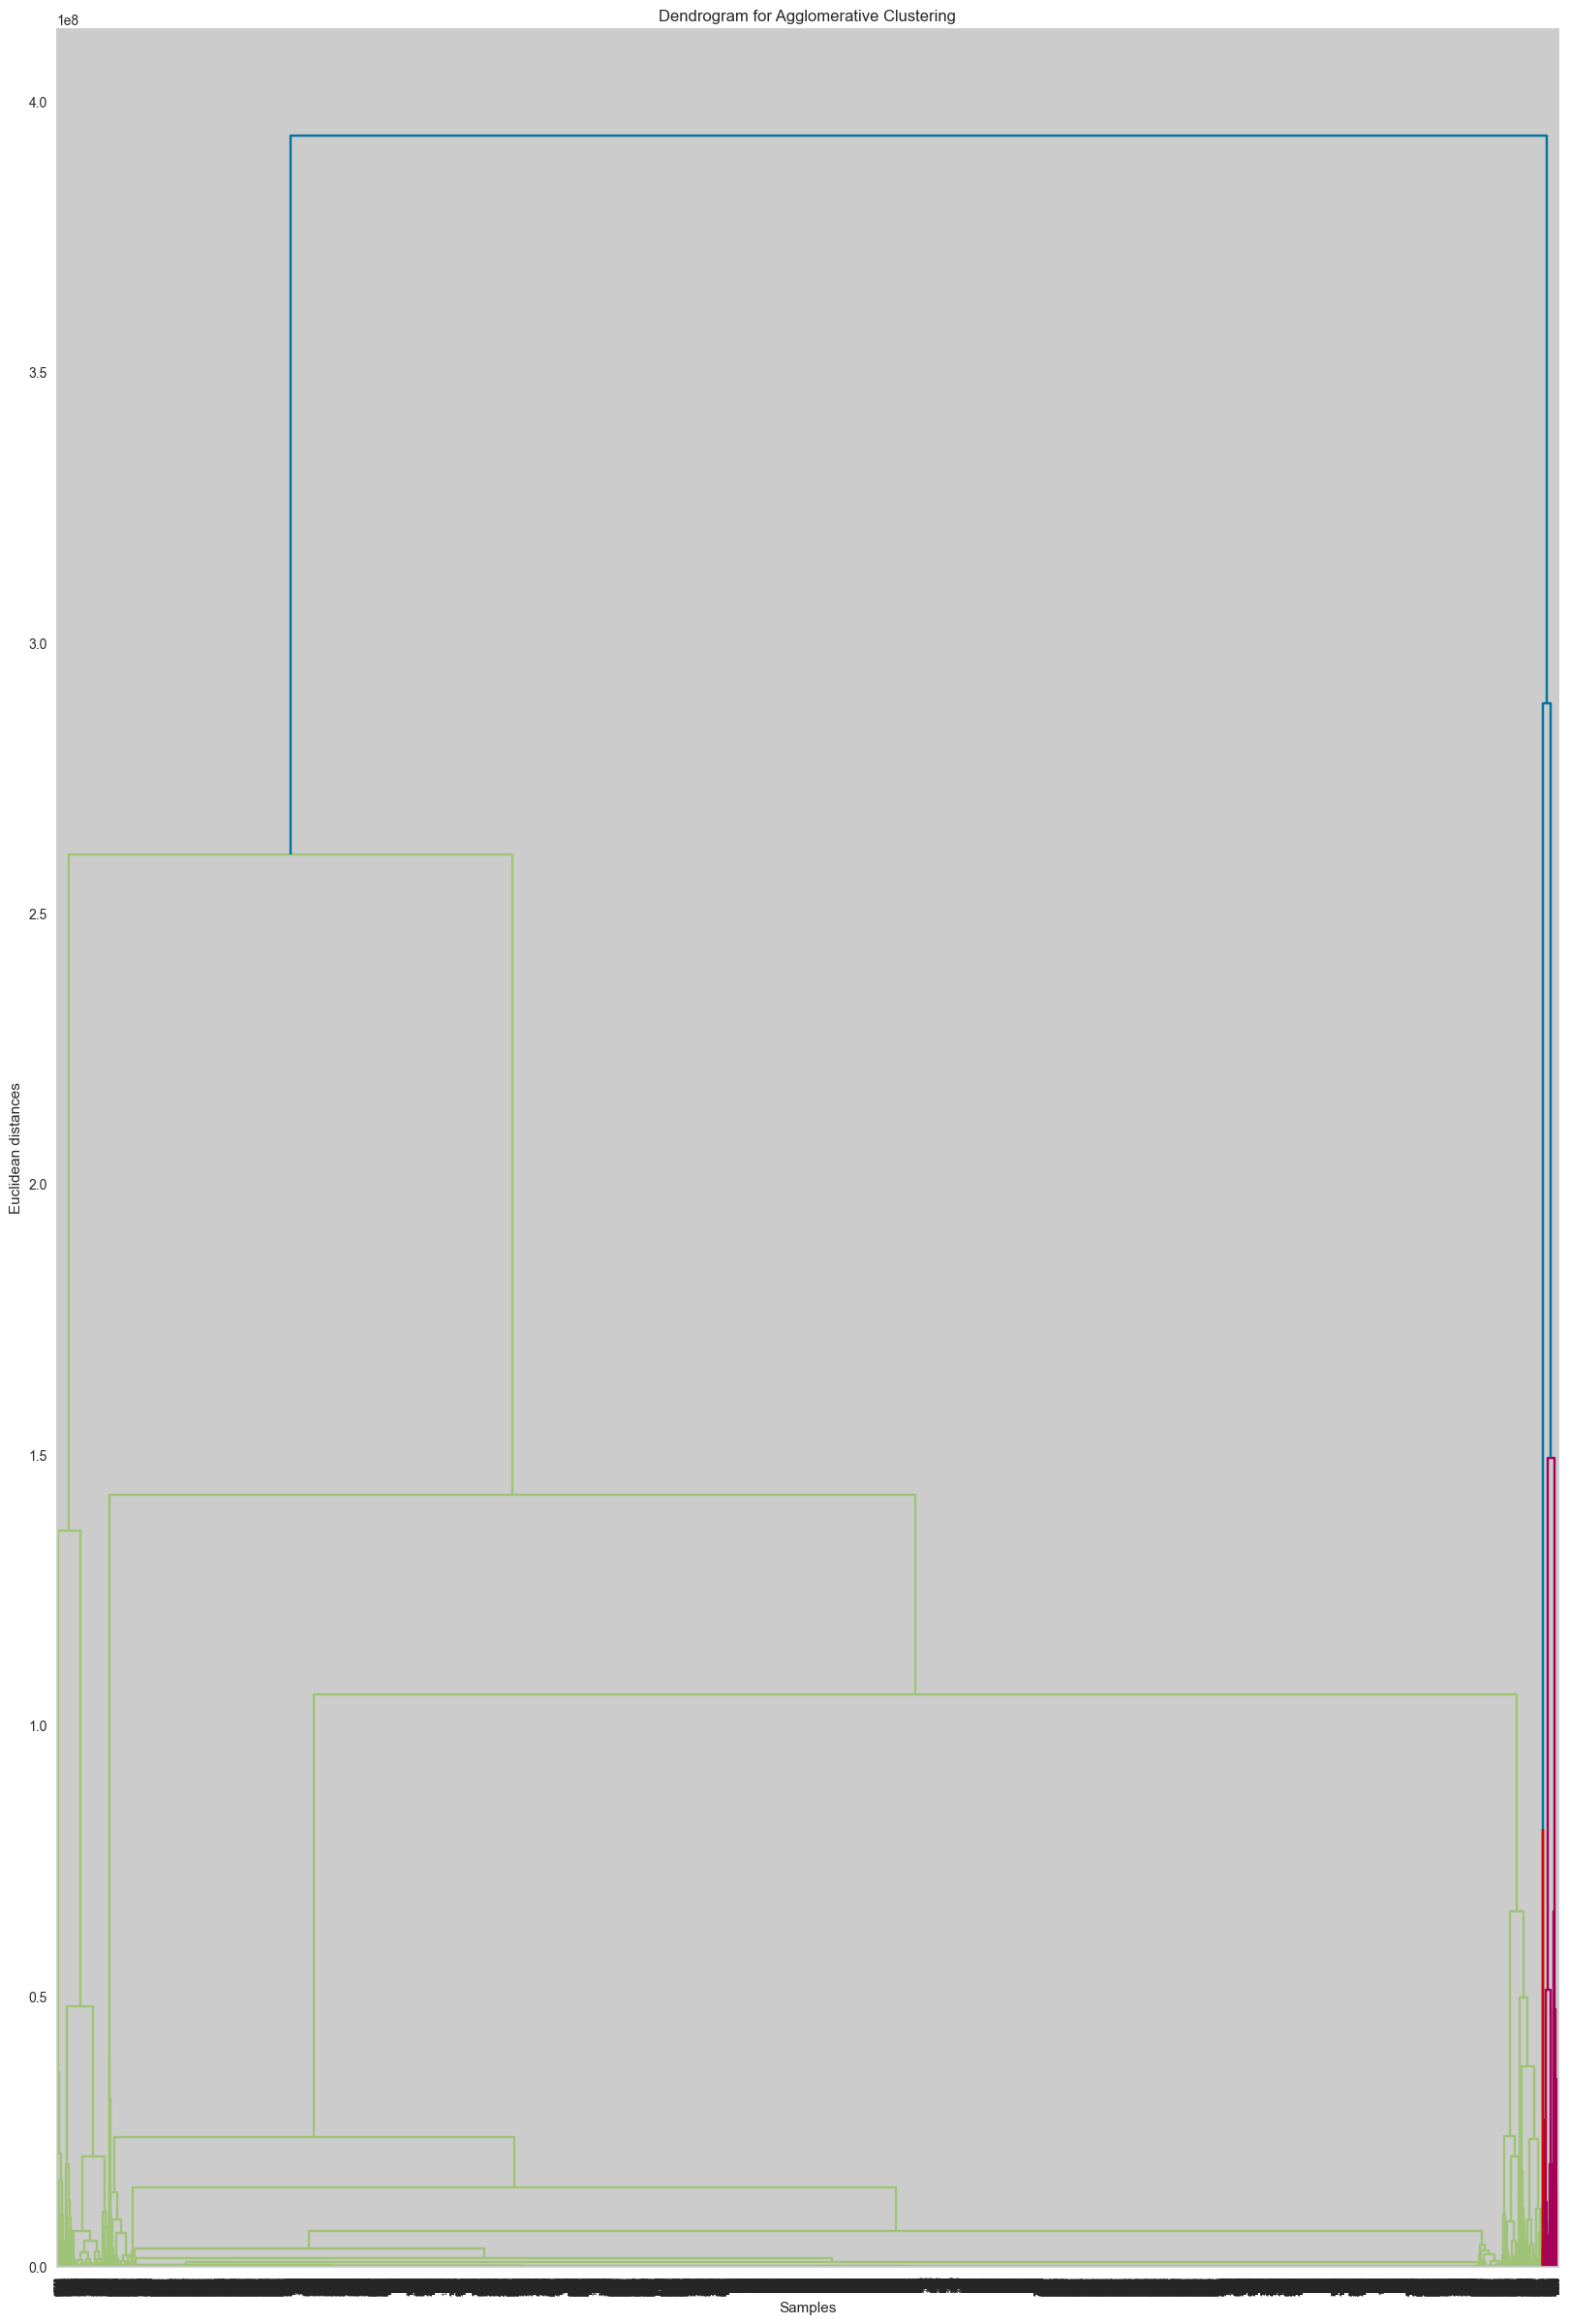

In [30]:
# Dendrogram for Agglomerative Clustering
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(20,30))
dendrogram = sch.dendrogram(sch.linkage(X_robust, method='ward'))
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()

4.2: Clustering Algoritms After Outlier Removal
- Due to mid results of clustering algorithms I will try every algorithms after removing outliers in this section

In [31]:
# Try clustering algorithms after outlier removal using Z-score
from scipy import stats
z_scores = np.abs(stats.zscore(X_scaled))
filtered_entries = (z_scores < 3).all(axis=1)
X_no_outliers = X_scaled[filtered_entries]

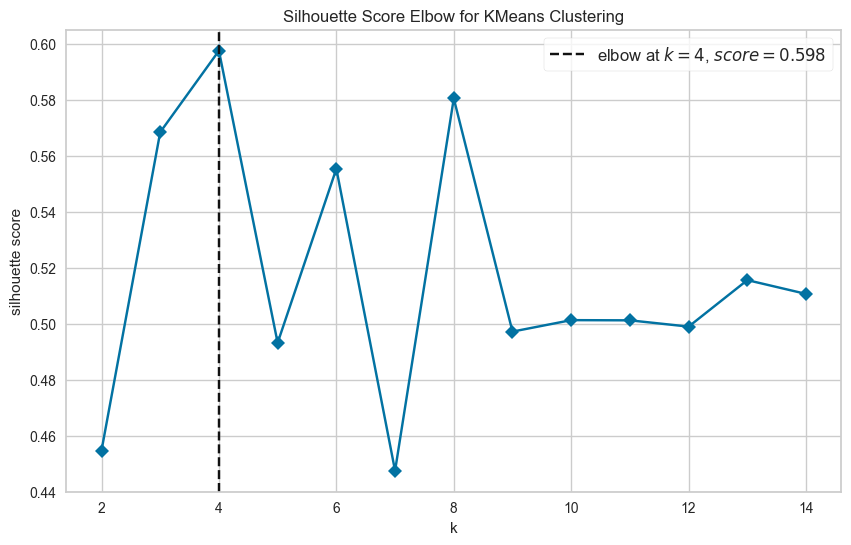

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [32]:
# Find optimal k for K-Means after outlier removal
plt.figure(figsize=(10,6))
model = KMeans(random_state=42)

# Try k from 2 to 15
visualizer = KElbowVisualizer(model, k=(2,15), metric='silhouette', timings=False)
visualizer.fit(X_no_outliers)        
visualizer.show()

In [58]:
# Visualizing K-Means Clusters using first two principal components
X_pca_2 = pca.fit_transform(X_no_outliers)
X_tsne_2 = tsne.fit_transform(X_no_outliers)

K-Means Silhouette Score:
0.5975652


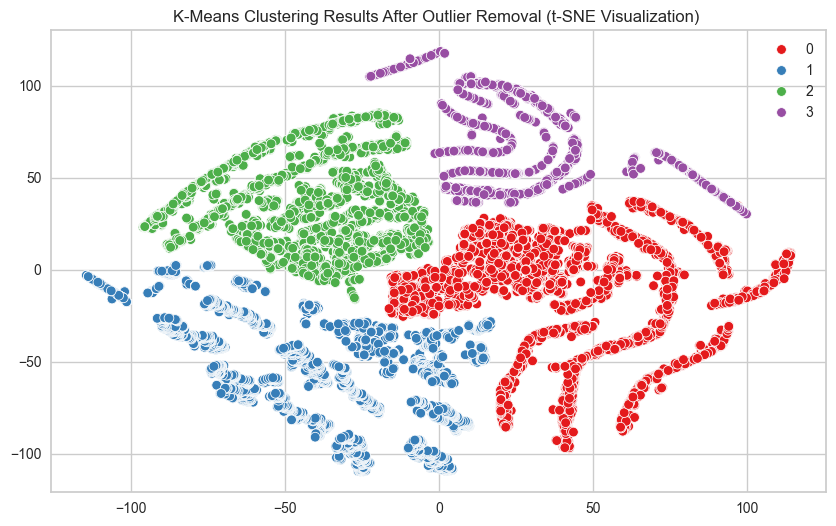

In [65]:
# K-Means Clustering after outlier removal
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_no_outliers)
kmeans_labels = kmeans.labels_
print("K-Means Silhouette Score:")
print(silhouette_score(X_no_outliers, kmeans_labels))


plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne_2[:,0], y=X_tsne_2[:,1], hue=kmeans_labels, palette='Set1', legend='full')
plt.title('K-Means Clustering Results After Outlier Removal (t-SNE Visualization) ')
plt.show()

# Observations on K-Means Clustering After Outlier Removing:
- According to silhouette score and visualization K-Means performed well after outlier removal
- Cluster seperation seems better than before outlier removal

DBSCAN Silhouette Score:
0.57161534


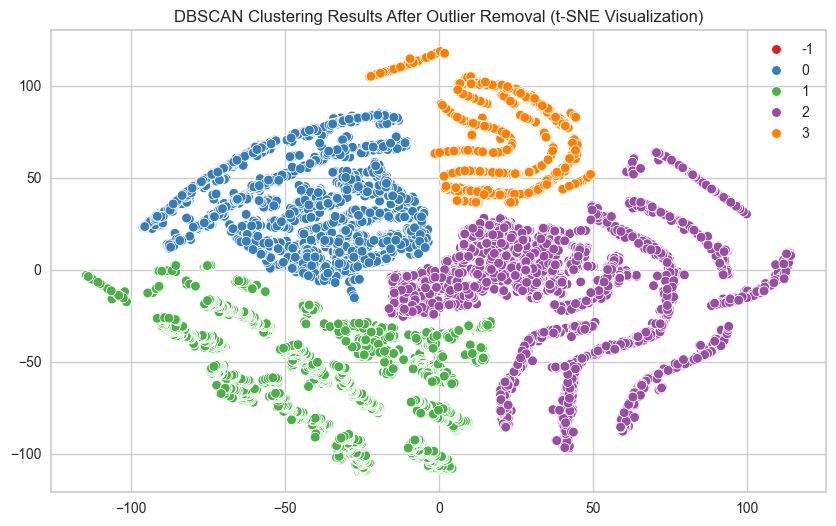

Number of noise points in DBSCAN: 14


In [81]:
# DBSCAN Clustering after outlier removal
dbscan = DBSCAN(eps=2, min_samples=15)
dbcan_labels = dbscan.fit_predict(X_pca_2)
print("DBSCAN Silhouette Score:")
print(silhouette_score(X_pca_2, dbcan_labels))

# Visualizing DBSCAN Clusters using first two principal components
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne_2[:,0], y=X_tsne_2[:,1], hue=dbcan_labels, palette='Set1', legend='full')
plt.title('DBSCAN Clustering Results After Outlier Removal (t-SNE Visualization)')
plt.show()

# Number of label -1 points in DBSCAN
print(f'Number of noise points in DBSCAN: {(dbcan_labels == -1).sum()}')

# Observations on DBSCAN Clustering After Outlier Removing:
- According to silhouette score and visualization DBSCAN performed better after outlier removal
- It seems performed so close to K-Means
- After outlier removal count of noise (-1 labels) also reduced significantly (476 -> 14)
- This shows that outlier removal helped DBSCAN to form better clusters

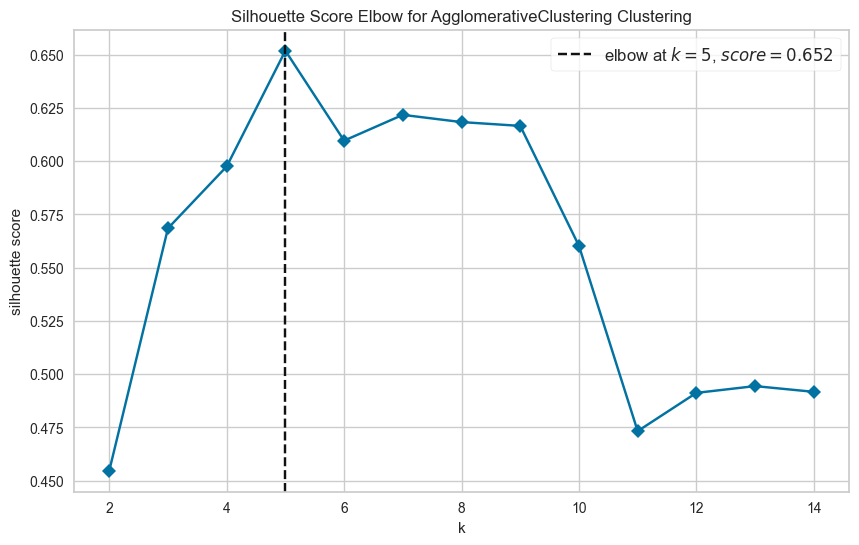

<Axes: title={'center': 'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [56]:
# find n_cluster for Agglomerative Clustering after outlier removal
plt.figure(figsize=(10,6))
model = AgglomerativeClustering()

# Try k from 2 to 15
visualizer = KElbowVisualizer(model, k=(2,15), metric='silhouette', timings=False)
visualizer.fit(X_no_outliers)        
visualizer.show()

Agglomerative Clustering Silhouette Score: 
0.6518097


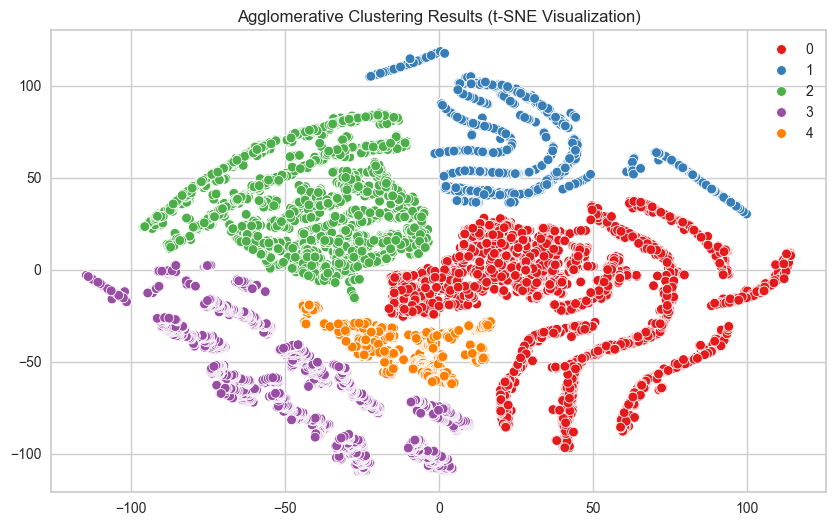

In [63]:
# Agglomerative Clustering after outlier removal
agglo = AgglomerativeClustering(n_clusters=5)
agglo_labels = agglo.fit_predict(X_no_outliers)
print('Agglomerative Clustering Silhouette Score: ')
print(silhouette_score(X_no_outliers, agglo_labels))

# Visualizing Agglomerative Clusters using first two principal components
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne_2[:,0], y=X_tsne_2[:,1], hue=agglo_labels, palette='Set1', legend='full')
plt.title('Agglomerative Clustering Results (t-SNE Visualization)')
plt.show()

# Observations on Agglomerative Clustering After Outlier Removal:
- According to silhouette score and visualizations Agglomerative Clustering performed best after outlier removal
- In plot we can see that it performed well to find smaller clusters too
- After all of these analysis we can conclude that outlier removal clearly improved all clustering algorithms performance

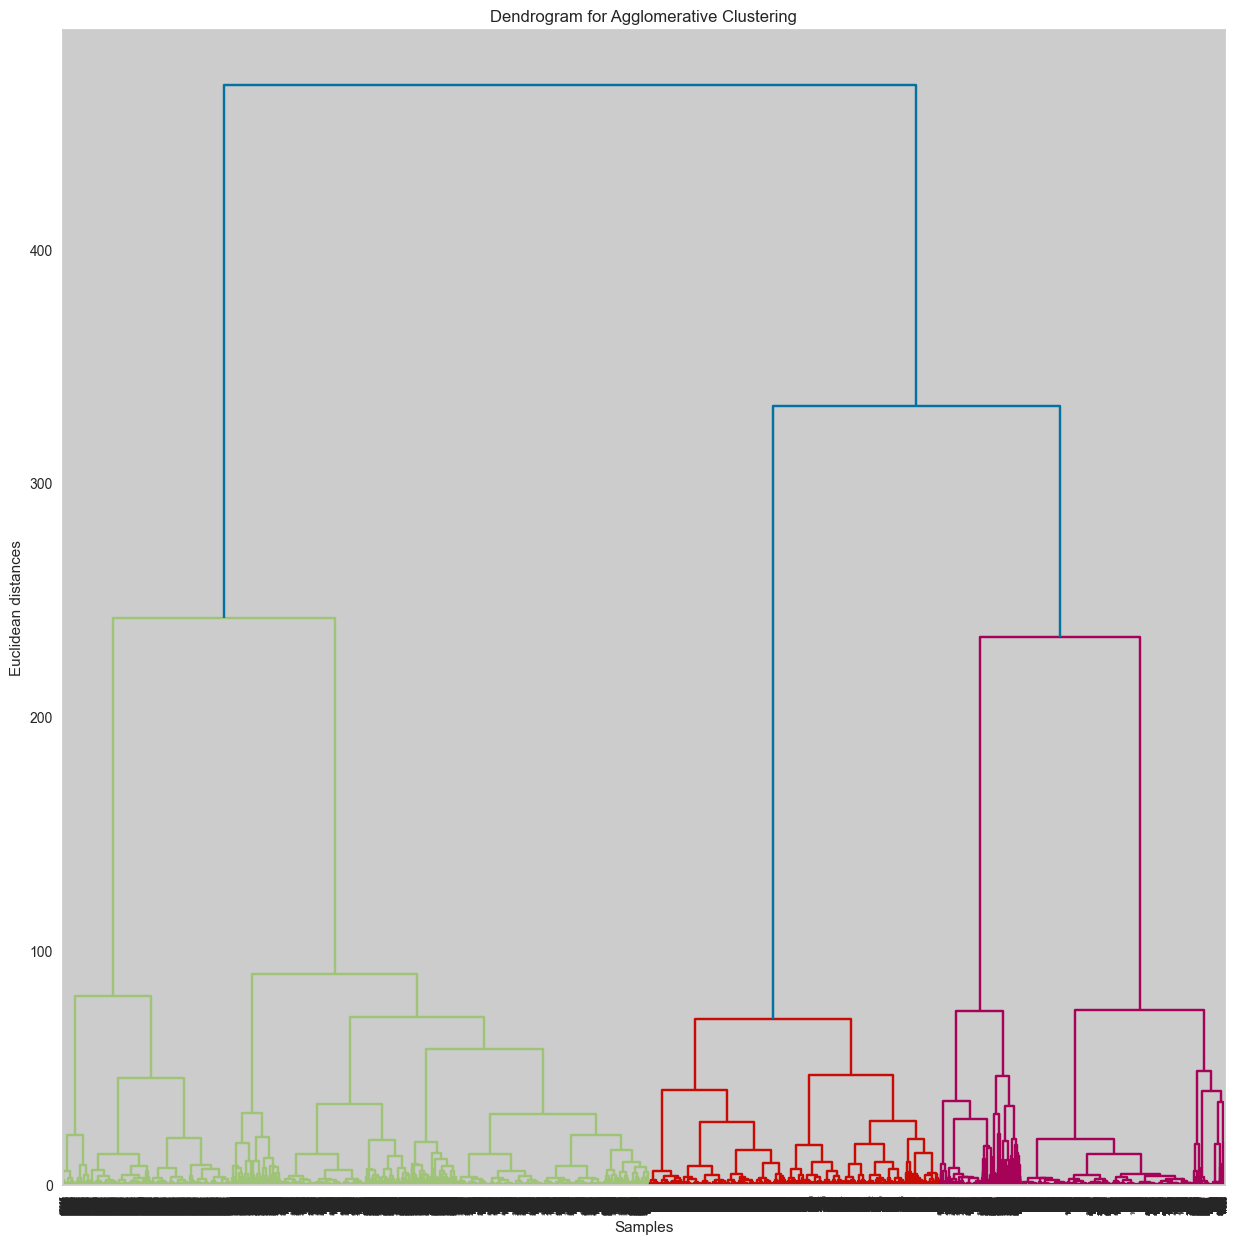

In [37]:
# Dendrogram for Agglomerative Clustering after outlier removal
plt.figure(figsize=(15,15))
dendrogram = sch.dendrogram(sch.linkage(X_no_outliers, method='ward'))
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()

# Observations on Dendogram Visualization:
- In dendogram we can see that optimal number of clusters is 5
- Also before outlier removal it was hard to decide the optimal number of clusters and it was hard to interpret the result of dendogram

# Part 5: Comparison and Analysis

5.1 - Classification Algorithms

- Among the classification models, Random Forest performed better than other models.
- Even for the small classes it achieved good precision and recall.
- According to feature importances from RFC, features 27,22,17 effect the most on classification
- But these features don't dominate the model so I keep all features for further modeling.
- RFC performed better than other models because it can handle high dimensional data well and is robust to outliers as well as non-linear relationships.
- SVM performed better than Logistic Regression because SVM can handle non-linear decision boundries using kernel trick.


5.2 - Clustering Algorithms

- Among the clustering algorithms, Agglomerative Clustering performed the best with silhouette score of around 0.5 both before and after outlier removal.
- DBSCAN algorithm found a lot of noise points before outlier removal
- K-Means showed moderate performance with silhouette score but not a good visual seperation
- After outlier removal, clustering performance clearly improved for all algorithms
- After outlier removal again Agglomerative Clustering showed best performance on silhouette score and visual seperation
- The reason of Agglomerative performing best could be its ability to capture complex cluster shapes and its hierarchical nature which is beneficial for high-dimensional data.
